In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
USE_GPU = torch.cuda.is_available()
BATCH_SIZE = 256

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Make data

In [2]:
x = np.array([(i,j) for i in range(-4, 5, 2) for j in range(-4, 5, 2)] * 10000)

In [3]:
x = x + 0.1 * np.random.randn(*x.shape)

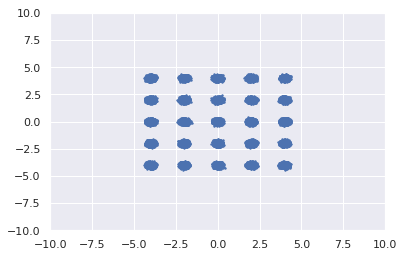

In [4]:
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

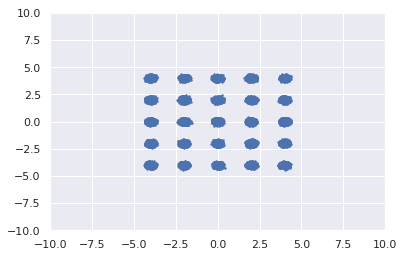

In [5]:
np.random.shuffle(x)
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

In [6]:
print(x.shape)

(250000, 2)


## Define Networks

In [7]:
class Generator(nn.Module):
    
    def __init__(self, input_size=10, output_size=2, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc2(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc3(x), negative_slope=2e-1)
        return x
        
class Discriminator(nn.Module):
    
    def __init__(self, input_size=2, output_size=1, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, hidden_size)
        self.fc_sigma = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc2(x), negative_slope=2e-1)
        mu = self.fc_mu(x)
        sigma = torch.sigmoid(self.fc_sigma(x))
        x = torch.sigmoid(F.leaky_relu(self.fc3(mu + sigma * torch.randn_like(sigma)), negative_slope=2e-1))
        return x, mu, sigma
        
class Mine(nn.Module):
    
    def __init__(self, noise_size=3, sample_size=2, output_size=1, hidden_size=128):
        super().__init__()
        self.fc1_noise = nn.Linear(noise_size, hidden_size, bias=False)
        self.fc1_sample = nn.Linear(sample_size, hidden_size, bias=False)
        self.fc1_bias = nn.Parameter(torch.zeros(hidden_size))
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.ma_et = None
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
                
    def forward(self, noise, sample):
        x_noise = self.fc1_noise(noise)
        x_sample = self.fc1_sample(sample)
        x = F.leaky_relu(x_noise + x_sample + self.fc1_bias, negative_slope=2e-1)
        x = F.leaky_relu(self.fc2(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc3(x), negative_slope=2e-1)
        return x

## Define training code

In [8]:
def update_target(ma_net, net, update_rate=1e-1):
        # update moving average network parameters using network
        for ma_net_param, net_param in zip(ma_net.parameters(), net.parameters()):
            ma_net_param.data.copy_((1.0 - update_rate) \
                                    * ma_net_param.data + update_rate*net_param.data)

In [9]:
def vib(mu, sigma, alpha=1e-8):
    d_kl = 0.5 * torch.mean((mu ** 2) + (sigma ** 2)
                                      - torch.log((sigma ** 2) + alpha) - 1)
    return d_kl

In [10]:
def learn_discriminator(x, G, D , M, D_opt, zero_gp=True, vdb=True):
    '''
    real_samples : torch.Tensor
    G : Generator network
    D : Discriminator network
    M : Mutual Information Neural Estimation(MINE) network
    D_opt : Optimizer of Discriminator
    '''
    z = torch.randn((BATCH_SIZE, 10))
    if USE_GPU:
        z = z.cuda()
        x = x.cuda()
    x_tilde = G(z)
    Dx_tilde, Dmu_tilde, Dsigma_tilde = D(x_tilde)
        
    if zero_gp:
        # zero centered gradient penalty  : https://arxiv.org/abs/1801.04406
        x.requires_grad = True
        Dx, Dmu, Dsigma = D(x)
        grad = torch.autograd.grad(Dx, x, create_graph=True,
                             grad_outputs=torch.ones_like(Dx),
                             retain_graph=True, only_inputs=True)[0].view(BATCH_SIZE, -1)
        grad = grad.norm(dim=1)
        gp_loss = torch.mean(grad**2)
    else:
        Dx, Dmu, Dsigma = D(x)
    
    if vdb:
        # information bottleneck
        vib_loss = (vib(Dmu, Dsigma) + vib(Dmu_tilde, Dsigma_tilde))/2
    
    loss = 0.
    gan_loss = - torch.log(Dx).mean() - torch.log(1-Dx_tilde).mean()
    loss += gan_loss
    if zero_gp:
        loss = gan_loss + 1.0 * gp_loss
    if vdb:
        loss += 0.1 * vib_loss
    
    D_opt.zero_grad()
    loss.backward()
    D_opt.step()
    
    if zero_gp:
        return gan_loss.item(), gp_loss.item()
    
    return gan_loss.item(), 0

In [11]:
def learn_generator(x, G, D, M, G_opt, G_ma, mi_obj=False):
    '''
    real_samples : torch.Tensor
    G : Generator network
    D : Discriminator network
    M : Mutual Information Neural Estimation(MINE) network
    G_opt : Optimizer of Generator
    mi_reg : add Mutual information objective
    '''
    z = torch.randn((BATCH_SIZE, 10))
    z_bar = torch.narrow(torch.randn((BATCH_SIZE, 10)), dim=1, start=0, length=3)
        # which is for product distribution.
    if USE_GPU:
        z = z.cuda()
        z_bar = z_bar.cuda()
        x = x.cuda()
    x_tilde = G(z)
    Dx_tilde, Dmu_tilde, Dsimga_tilde = D(x_tilde)
    
    loss = 0.
    gan_loss = torch.log(1-Dx_tilde).mean()
    loss += gan_loss
    if mi_obj:
        z = torch.narrow(z, dim=1, start=0, length=3) # slice for MI
        mi = torch.mean(M(z, x_tilde)) - torch.log(torch.mean(torch.exp(M(z_bar, x_tilde)))+1e-8)
        loss -= 0.01 * mi
    
    G_opt.zero_grad()
    loss.backward()
    G_opt.step()
    
    # EMA GAN : https://arxiv.org/abs/1806.04498
    update_target(G_ma, G)
    
    return gan_loss.item()

In [12]:
def learn_mine(G, M, M_opt, ma_rate=0.001):
    '''
    Mine is learning for MI of (input, output) of Generator.
    '''
    z = torch.randn((BATCH_SIZE, 10))
    # which is the input of Generator.
    z_bar = torch.narrow(torch.randn((BATCH_SIZE, 10)), dim=1, start=0, length=3)
    # which is for product distribution.
    if USE_GPU:
        z = z.cuda()
        z_bar = z_bar.cuda()
    x_tilde = G(z) # which is the output of Generator.
    
    et = torch.mean(torch.exp(M(z_bar, x_tilde)))
    if M.ma_et is None:
        M.ma_et = et.detach().item()
    M.ma_et += ma_rate * (et.detach().item() - M.ma_et)
    z = torch.narrow(z, dim=1, start=0, length=3) # slice for MI
    mutual_information = torch.mean(M(z, x_tilde)) \
    - torch.log(et) * et.detach() /M.ma_et
    loss = - mutual_information
    
    M_opt.zero_grad()
    loss.backward()
    M_opt.step()
    
    return mutual_information.item()

In [13]:
z_test = torch.randn((20000, 10))
if USE_GPU:
    z_test = z_test.cuda()
def train(epoch_num=300, is_zero_gp=False, is_mi_obj=False):
    for i in range(1, epoch_num+1):
        np.random.shuffle(x)
        iter_num = len(x) // BATCH_SIZE
        d_loss_arr, gp_loss_arr, g_loss_arr, mi_arr = [], [], [], []
        for j in tqdm(range(iter_num)):
            batch = torch.FloatTensor(x[BATCH_SIZE * j : BATCH_SIZE * j + BATCH_SIZE])
            d_loss, gp_loss = learn_discriminator(batch, G, D, M, D_opt, zero_gp=is_zero_gp)
            g_loss = learn_generator(batch, G, D, M, G_opt, G_ma, mi_obj=is_mi_obj)
            mi = learn_mine(G, M, M_opt)
            
            d_loss_arr.append(d_loss)
            gp_loss_arr.append(gp_loss)
            g_loss_arr.append(g_loss)
            mi_arr.append(mi)
        print('D loss : {0}, GP_loss : {1} G_loss : {2}, MI : {3}'.format(
            round(np.mean(d_loss_arr),4), round(np.mean(gp_loss_arr)),
            round(np.mean(g_loss_arr),4), round(np.mean(mi_arr),4)))
        x_test = G_ma(z_test).data.cpu().numpy()
        plt.title('Epoch {0}'.format(i))
        plt.scatter(x_test[:,0], x_test[:,1], s=2.0)
        plt.xlim((-10, 10))
        plt.ylim((-10, 10))
        plt.show()

100%|██████████| 976/976 [00:08<00:00, 124.79it/s]


D loss : 1.3071, GP_loss : 0.0 G_loss : -0.6932, MI : 0.2709


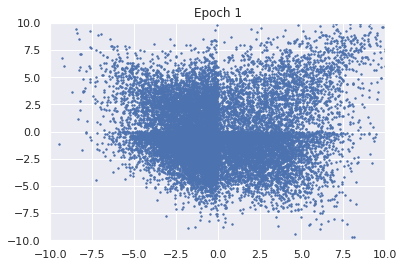

100%|██████████| 976/976 [00:07<00:00, 124.51it/s]


D loss : 1.3443, GP_loss : 0.0 G_loss : -0.7041, MI : 0.3115


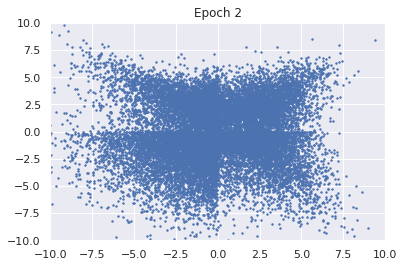

100%|██████████| 976/976 [00:07<00:00, 124.30it/s]


D loss : 1.3564, GP_loss : 0.0 G_loss : -0.6966, MI : 0.3553


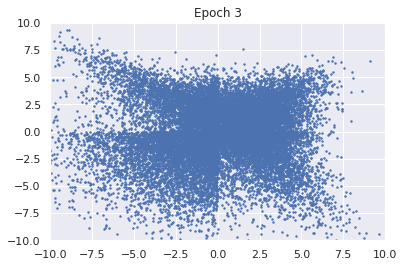

100%|██████████| 976/976 [00:07<00:00, 126.45it/s]


D loss : 1.3413, GP_loss : 0.0 G_loss : -0.7378, MI : 0.3861


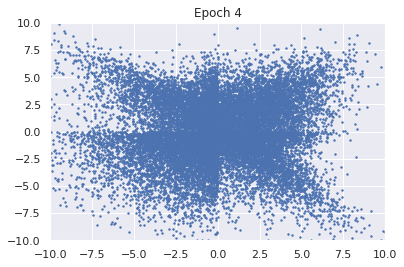

100%|██████████| 976/976 [00:07<00:00, 122.71it/s]


D loss : 1.3199, GP_loss : 0.0 G_loss : -0.761, MI : 0.3739


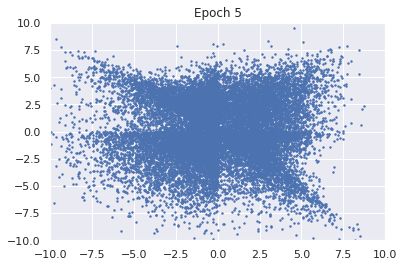

100%|██████████| 976/976 [00:07<00:00, 124.06it/s]


D loss : 1.297, GP_loss : 0.0 G_loss : -0.7726, MI : 0.3361


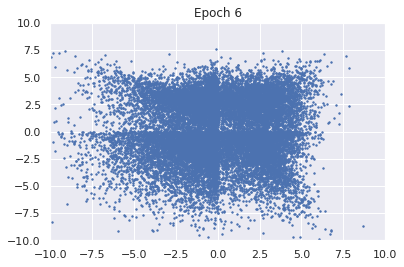

100%|██████████| 976/976 [00:07<00:00, 125.28it/s]


D loss : 1.2832, GP_loss : 0.0 G_loss : -0.7788, MI : 0.3235


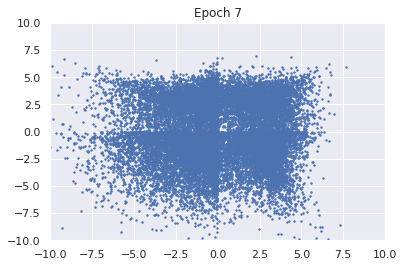

100%|██████████| 976/976 [00:07<00:00, 123.94it/s]


D loss : 1.2687, GP_loss : 0.0 G_loss : -0.7814, MI : 0.3017


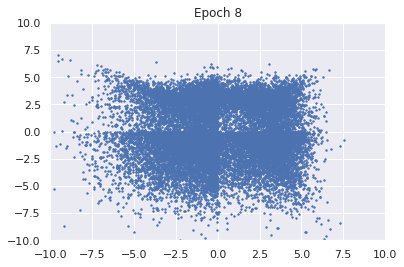

100%|██████████| 976/976 [00:07<00:00, 123.93it/s]


D loss : 1.2558, GP_loss : 0.0 G_loss : -0.7839, MI : 0.3123


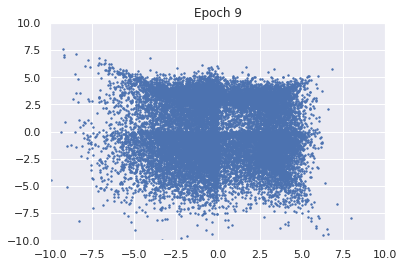

100%|██████████| 976/976 [00:07<00:00, 124.17it/s]


D loss : 1.2469, GP_loss : 0.0 G_loss : -0.7847, MI : 0.3081


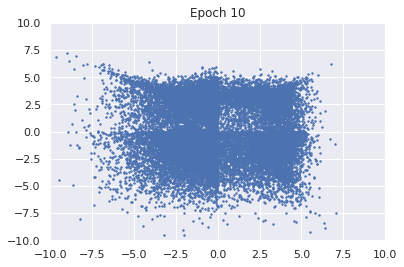

100%|██████████| 976/976 [00:07<00:00, 125.38it/s]


D loss : 1.2427, GP_loss : 0.0 G_loss : -0.7862, MI : 0.3047


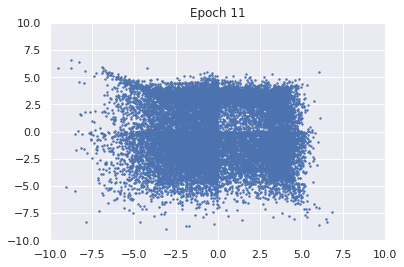

100%|██████████| 976/976 [00:07<00:00, 122.62it/s]


D loss : 1.2426, GP_loss : 0.0 G_loss : -0.7876, MI : 0.3132


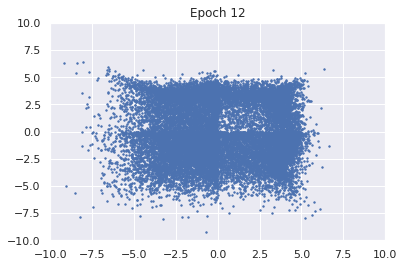

100%|██████████| 976/976 [00:07<00:00, 124.09it/s]


D loss : 1.2449, GP_loss : 0.0 G_loss : -0.7862, MI : 0.3117


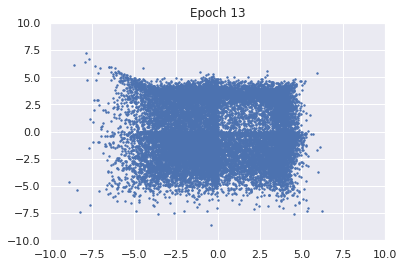

100%|██████████| 976/976 [00:07<00:00, 123.64it/s]


D loss : 1.2489, GP_loss : 0.0 G_loss : -0.7863, MI : 0.3046


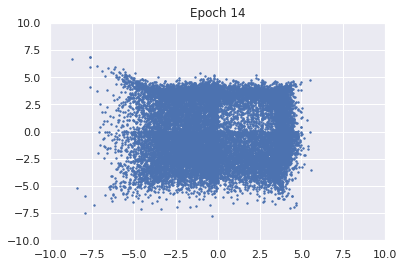

100%|██████████| 976/976 [00:08<00:00, 120.68it/s]


D loss : 1.2543, GP_loss : 0.0 G_loss : -0.7868, MI : 0.29


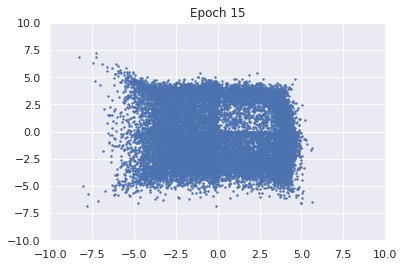

100%|██████████| 976/976 [00:07<00:00, 123.79it/s]


D loss : 1.2615, GP_loss : 0.0 G_loss : -0.7857, MI : 0.2946


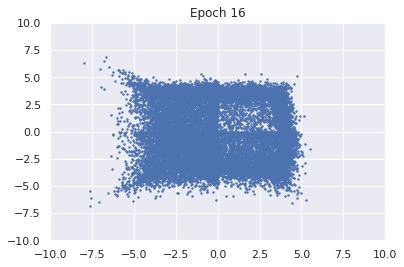

100%|██████████| 976/976 [00:07<00:00, 123.22it/s]


D loss : 1.2689, GP_loss : 0.0 G_loss : -0.7867, MI : 0.3042


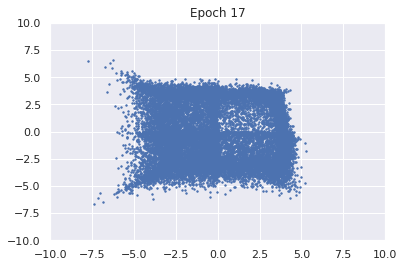

100%|██████████| 976/976 [00:07<00:00, 122.85it/s]


D loss : 1.2748, GP_loss : 0.0 G_loss : -0.7863, MI : 0.3047


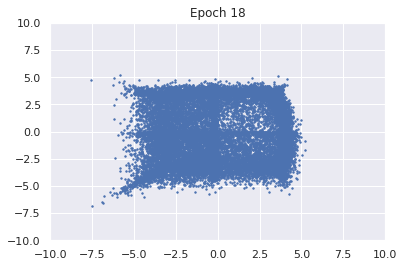

100%|██████████| 976/976 [00:07<00:00, 123.22it/s]


D loss : 1.2768, GP_loss : 0.0 G_loss : -0.7863, MI : 0.3031


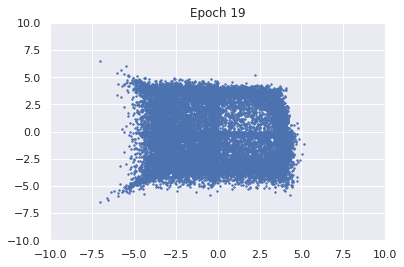

100%|██████████| 976/976 [00:07<00:00, 123.16it/s]


D loss : 1.2799, GP_loss : 0.0 G_loss : -0.7874, MI : 0.313


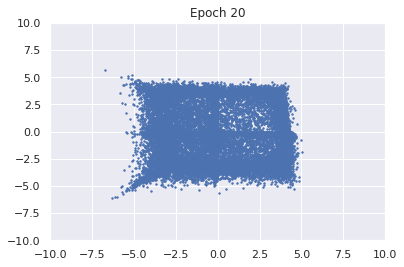

100%|██████████| 976/976 [00:07<00:00, 123.02it/s]


D loss : 1.2826, GP_loss : 0.0 G_loss : -0.7852, MI : 0.3066


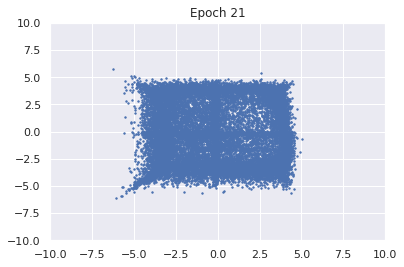

100%|██████████| 976/976 [00:07<00:00, 123.66it/s]


D loss : 1.2835, GP_loss : 0.0 G_loss : -0.7828, MI : 0.298


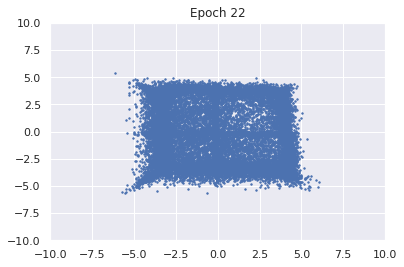

100%|██████████| 976/976 [00:07<00:00, 122.52it/s]


D loss : 1.2852, GP_loss : 0.0 G_loss : -0.7817, MI : 0.2978


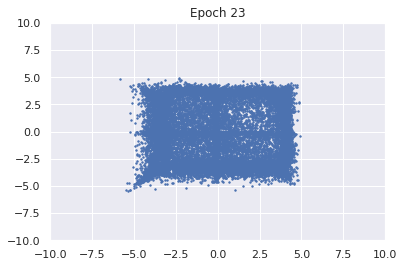

100%|██████████| 976/976 [00:08<00:00, 121.00it/s]


D loss : 1.2843, GP_loss : 0.0 G_loss : -0.7803, MI : 0.2993


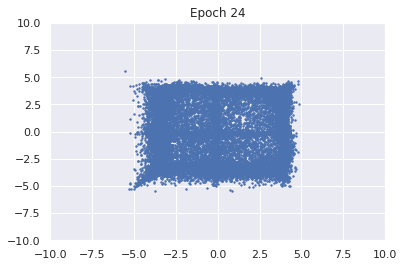

100%|██████████| 976/976 [00:07<00:00, 122.45it/s]


D loss : 1.2846, GP_loss : 0.0 G_loss : -0.7786, MI : 0.2928


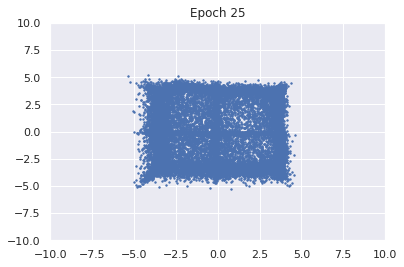

100%|██████████| 976/976 [00:07<00:00, 128.08it/s]


D loss : 1.2847, GP_loss : 0.0 G_loss : -0.7784, MI : 0.2885


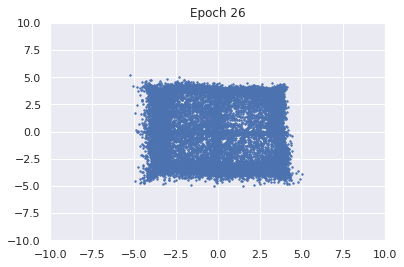

100%|██████████| 976/976 [00:07<00:00, 126.58it/s]


D loss : 1.2846, GP_loss : 0.0 G_loss : -0.7765, MI : 0.2809


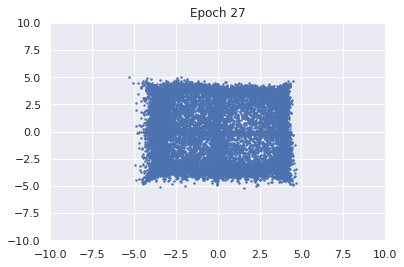

100%|██████████| 976/976 [00:07<00:00, 123.07it/s]


D loss : 1.2861, GP_loss : 0.0 G_loss : -0.7758, MI : 0.2803


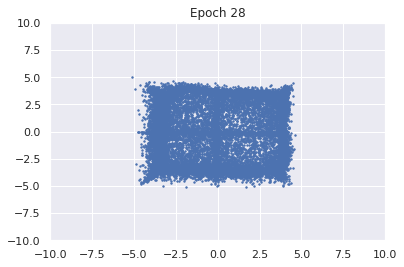

100%|██████████| 976/976 [00:07<00:00, 123.21it/s]


D loss : 1.2829, GP_loss : 0.0 G_loss : -0.7761, MI : 0.2959


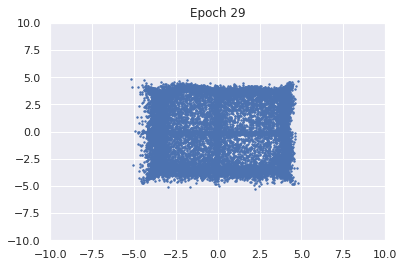

100%|██████████| 976/976 [00:07<00:00, 122.85it/s]


D loss : 1.283, GP_loss : 0.0 G_loss : -0.7764, MI : 0.2972


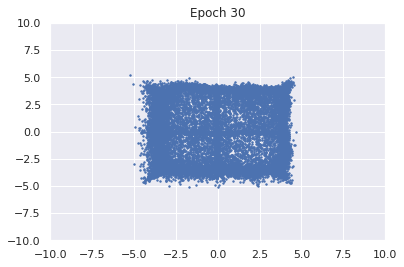

100%|██████████| 976/976 [00:07<00:00, 122.69it/s]


D loss : 1.285, GP_loss : 0.0 G_loss : -0.7763, MI : 0.3004


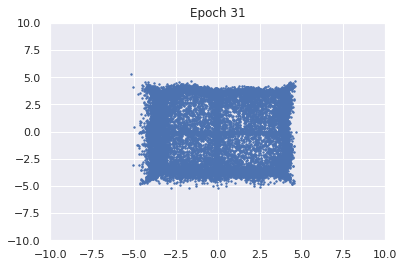

100%|██████████| 976/976 [00:07<00:00, 126.75it/s]


D loss : 1.2846, GP_loss : 0.0 G_loss : -0.7767, MI : 0.3013


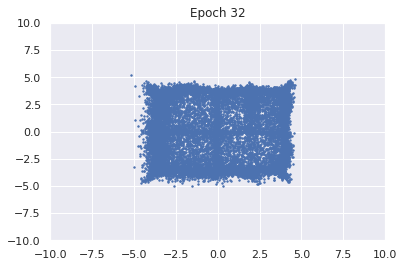

100%|██████████| 976/976 [00:07<00:00, 128.10it/s]


D loss : 1.2894, GP_loss : 0.0 G_loss : -0.7762, MI : 0.2986


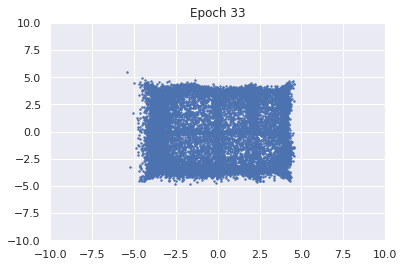

100%|██████████| 976/976 [00:07<00:00, 123.95it/s]


D loss : 1.2914, GP_loss : 0.0 G_loss : -0.7752, MI : 0.302


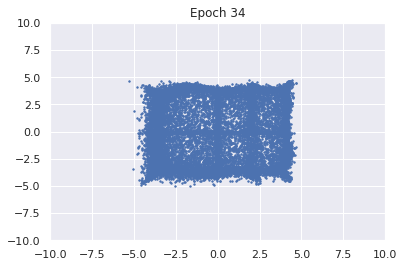

100%|██████████| 976/976 [00:07<00:00, 122.87it/s]


D loss : 1.294, GP_loss : 0.0 G_loss : -0.7757, MI : 0.3036


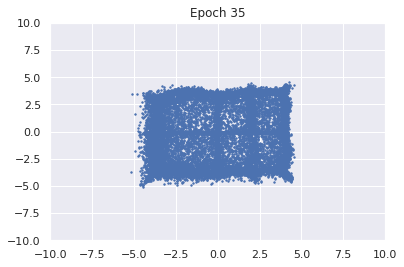

100%|██████████| 976/976 [00:07<00:00, 123.20it/s]


D loss : 1.2965, GP_loss : 0.0 G_loss : -0.774, MI : 0.3045


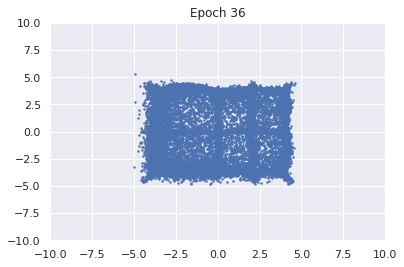

100%|██████████| 976/976 [00:07<00:00, 122.85it/s]


D loss : 1.2958, GP_loss : 0.0 G_loss : -0.7743, MI : 0.3137


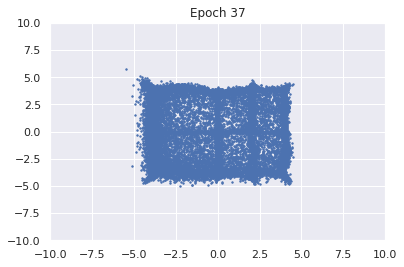

100%|██████████| 976/976 [00:07<00:00, 122.97it/s]


D loss : 1.2978, GP_loss : 0.0 G_loss : -0.7735, MI : 0.3161


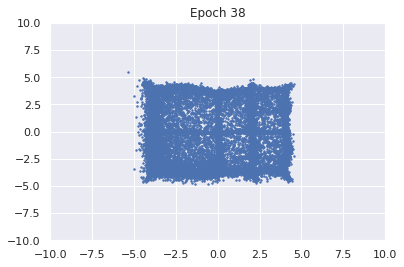

100%|██████████| 976/976 [00:07<00:00, 128.51it/s]


D loss : 1.2983, GP_loss : 0.0 G_loss : -0.7744, MI : 0.3176


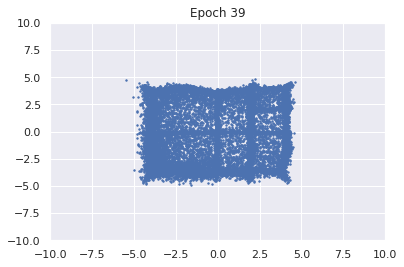

100%|██████████| 976/976 [00:07<00:00, 128.66it/s]


D loss : 1.2983, GP_loss : 0.0 G_loss : -0.7747, MI : 0.3178


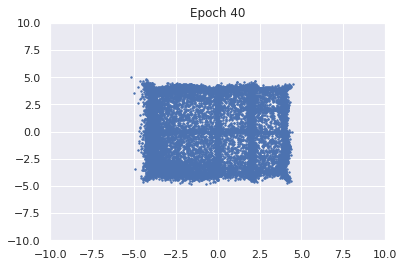

100%|██████████| 976/976 [00:07<00:00, 125.89it/s]


D loss : 1.2988, GP_loss : 0.0 G_loss : -0.7741, MI : 0.3186


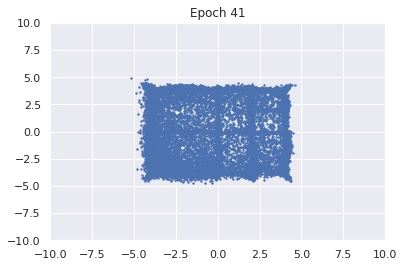

100%|██████████| 976/976 [00:07<00:00, 123.31it/s]


D loss : 1.3003, GP_loss : 0.0 G_loss : -0.7746, MI : 0.3152


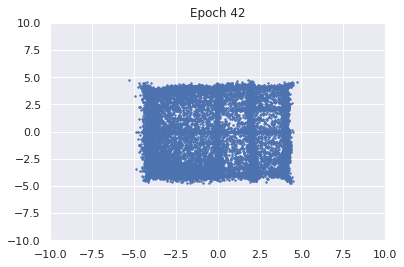

100%|██████████| 976/976 [00:07<00:00, 122.52it/s]


D loss : 1.3018, GP_loss : 0.0 G_loss : -0.7732, MI : 0.3247


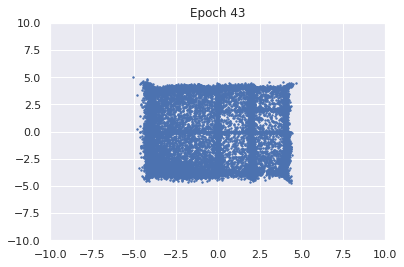

100%|██████████| 976/976 [00:08<00:00, 120.21it/s]


D loss : 1.3027, GP_loss : 0.0 G_loss : -0.7739, MI : 0.3193


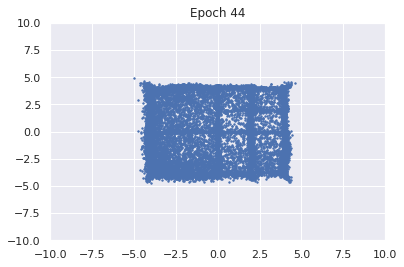

100%|██████████| 976/976 [00:07<00:00, 123.00it/s]


D loss : 1.3037, GP_loss : 0.0 G_loss : -0.773, MI : 0.3279


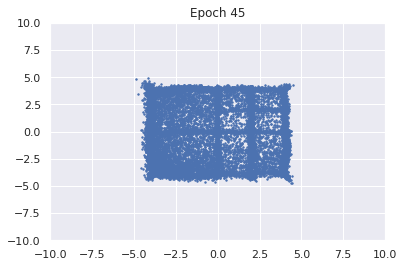

100%|██████████| 976/976 [00:07<00:00, 125.38it/s]


D loss : 1.3049, GP_loss : 0.0 G_loss : -0.7732, MI : 0.3252


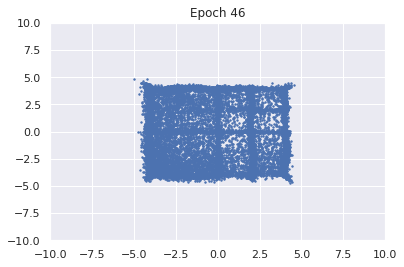

100%|██████████| 976/976 [00:07<00:00, 124.03it/s]


D loss : 1.307, GP_loss : 0.0 G_loss : -0.7731, MI : 0.3187


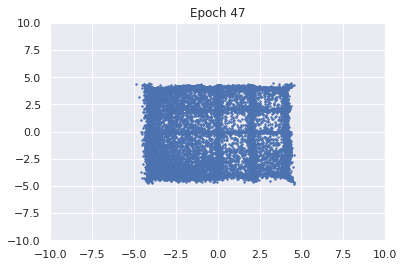

100%|██████████| 976/976 [00:07<00:00, 122.24it/s]


D loss : 1.309, GP_loss : 0.0 G_loss : -0.7713, MI : 0.32


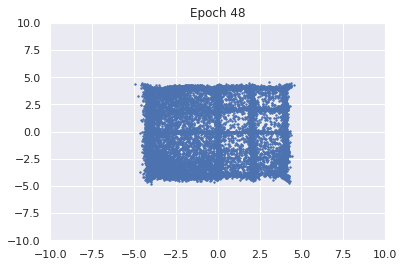

100%|██████████| 976/976 [00:07<00:00, 122.36it/s]


D loss : 1.3091, GP_loss : 0.0 G_loss : -0.7726, MI : 0.329


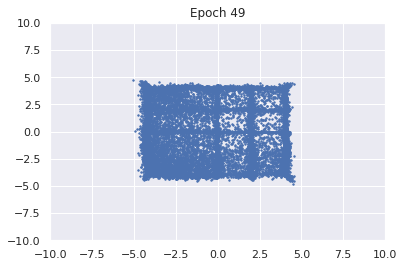

100%|██████████| 976/976 [00:08<00:00, 120.73it/s]


D loss : 1.3099, GP_loss : 0.0 G_loss : -0.7737, MI : 0.3319


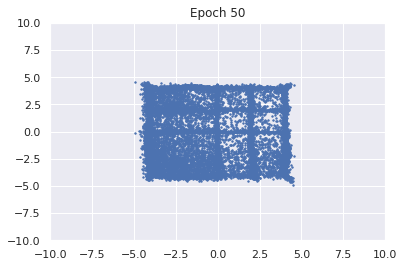

100%|██████████| 976/976 [00:07<00:00, 126.04it/s]


D loss : 1.3136, GP_loss : 0.0 G_loss : -0.7721, MI : 0.3365


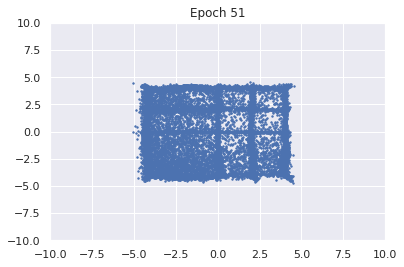

100%|██████████| 976/976 [00:07<00:00, 122.91it/s]


D loss : 1.3159, GP_loss : 0.0 G_loss : -0.7721, MI : 0.3397


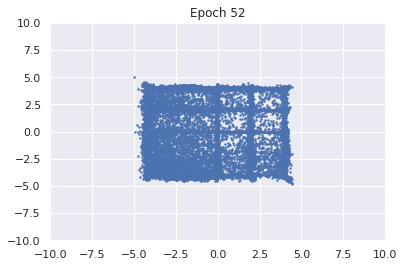

100%|██████████| 976/976 [00:07<00:00, 123.05it/s]


D loss : 1.3179, GP_loss : 0.0 G_loss : -0.7714, MI : 0.3455


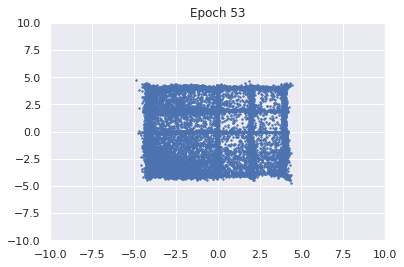

100%|██████████| 976/976 [00:07<00:00, 123.92it/s]


D loss : 1.3194, GP_loss : 0.0 G_loss : -0.7713, MI : 0.3458


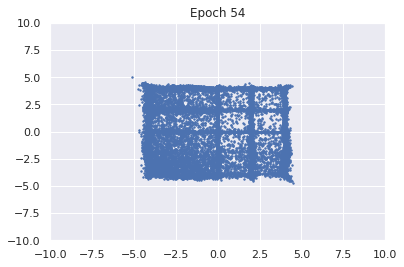

100%|██████████| 976/976 [00:07<00:00, 124.73it/s]


D loss : 1.3204, GP_loss : 0.0 G_loss : -0.7709, MI : 0.3465


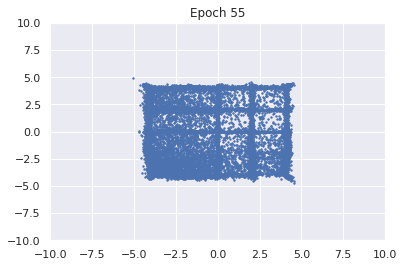

100%|██████████| 976/976 [00:07<00:00, 123.17it/s]


D loss : 1.3213, GP_loss : 0.0 G_loss : -0.7707, MI : 0.3493


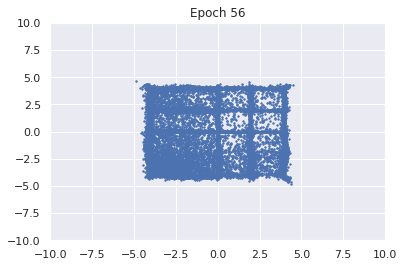

100%|██████████| 976/976 [00:07<00:00, 122.43it/s]


D loss : 1.3226, GP_loss : 0.0 G_loss : -0.7699, MI : 0.3455


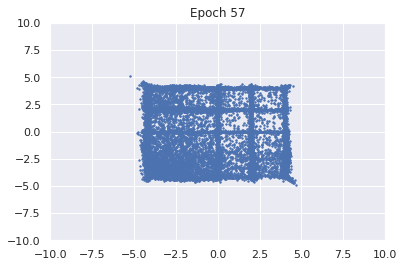

100%|██████████| 976/976 [00:07<00:00, 122.77it/s]


D loss : 1.3233, GP_loss : 0.0 G_loss : -0.7693, MI : 0.3502


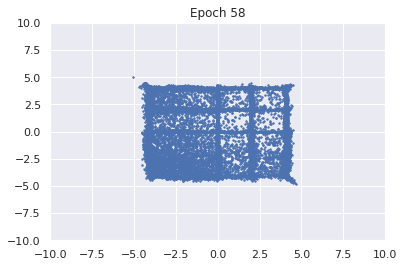

100%|██████████| 976/976 [00:07<00:00, 122.49it/s]


D loss : 1.3238, GP_loss : 0.0 G_loss : -0.768, MI : 0.3526


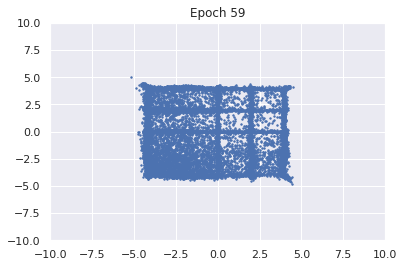

100%|██████████| 976/976 [00:07<00:00, 126.98it/s]


D loss : 1.3243, GP_loss : 0.0 G_loss : -0.7686, MI : 0.3517


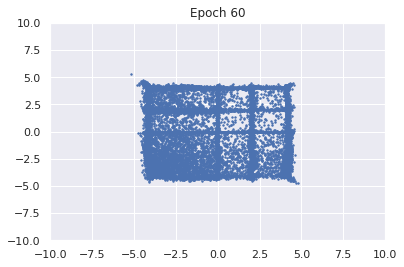

100%|██████████| 976/976 [00:07<00:00, 123.61it/s]


D loss : 1.3251, GP_loss : 0.0 G_loss : -0.7684, MI : 0.3576


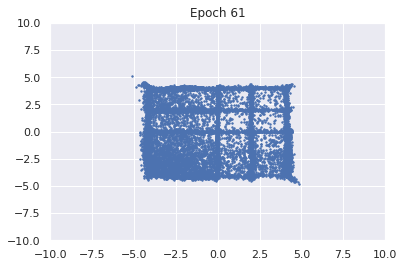

100%|██████████| 976/976 [00:07<00:00, 122.76it/s]


D loss : 1.325, GP_loss : 0.0 G_loss : -0.7691, MI : 0.3555


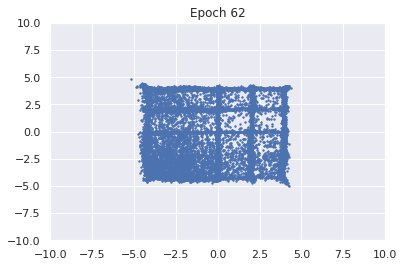

100%|██████████| 976/976 [00:07<00:00, 122.82it/s]


D loss : 1.3254, GP_loss : 0.0 G_loss : -0.7679, MI : 0.346


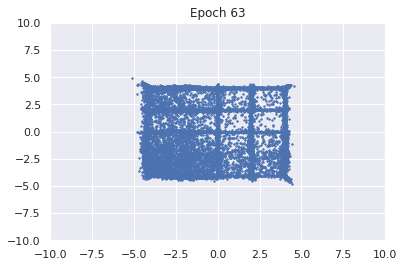

100%|██████████| 976/976 [00:07<00:00, 122.60it/s]


D loss : 1.3254, GP_loss : 0.0 G_loss : -0.7692, MI : 0.3493


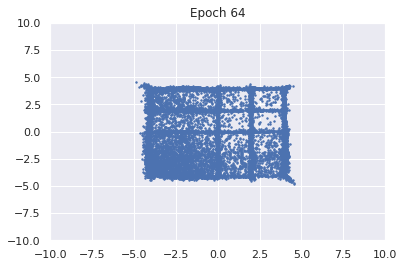

100%|██████████| 976/976 [00:07<00:00, 125.97it/s]


D loss : 1.3267, GP_loss : 0.0 G_loss : -0.769, MI : 0.355


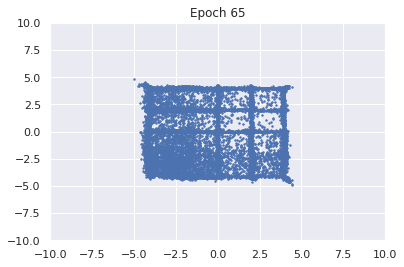

100%|██████████| 976/976 [00:07<00:00, 123.63it/s]


D loss : 1.3273, GP_loss : 0.0 G_loss : -0.7686, MI : 0.354


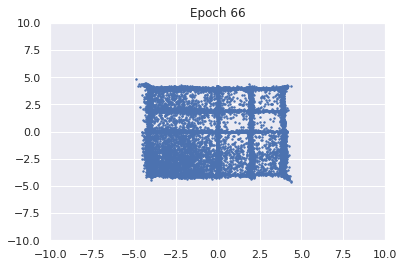

100%|██████████| 976/976 [00:07<00:00, 122.08it/s]


D loss : 1.3284, GP_loss : 0.0 G_loss : -0.7668, MI : 0.3591


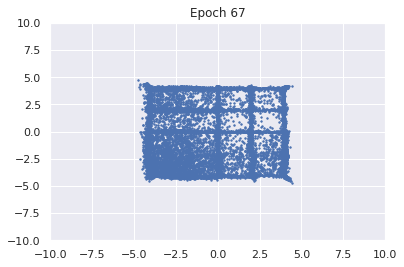

100%|██████████| 976/976 [00:08<00:00, 119.40it/s]


D loss : 1.3282, GP_loss : 0.0 G_loss : -0.7691, MI : 0.3474


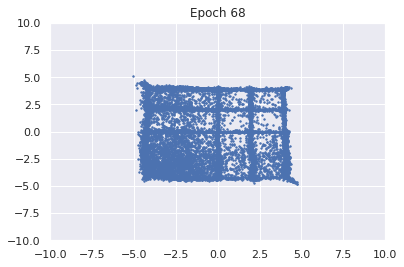

100%|██████████| 976/976 [00:07<00:00, 123.67it/s]


D loss : 1.329, GP_loss : 0.0 G_loss : -0.7689, MI : 0.3474


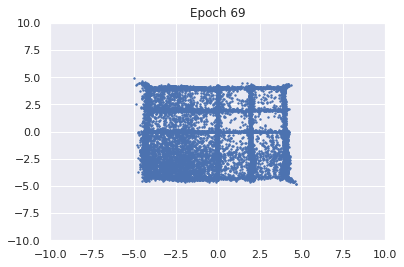

100%|██████████| 976/976 [00:07<00:00, 123.36it/s]


D loss : 1.3308, GP_loss : 0.0 G_loss : -0.7668, MI : 0.3508


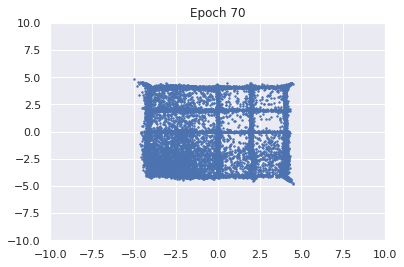

100%|██████████| 976/976 [00:07<00:00, 123.91it/s]


D loss : 1.33, GP_loss : 0.0 G_loss : -0.7687, MI : 0.3507


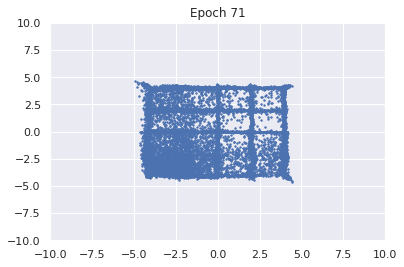

100%|██████████| 976/976 [00:07<00:00, 123.77it/s]


D loss : 1.3317, GP_loss : 0.0 G_loss : -0.7685, MI : 0.3478


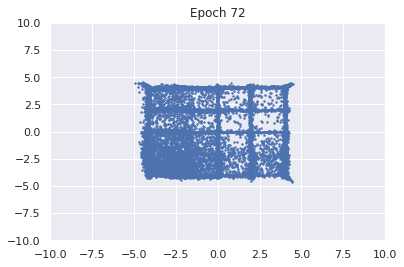

100%|██████████| 976/976 [00:07<00:00, 125.84it/s]


D loss : 1.3323, GP_loss : 0.0 G_loss : -0.7687, MI : 0.3482


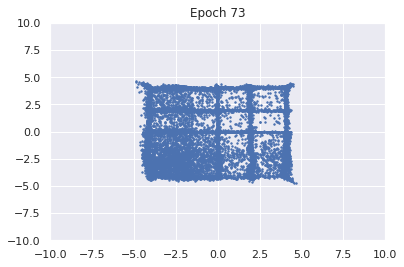

100%|██████████| 976/976 [00:07<00:00, 124.45it/s]


D loss : 1.3338, GP_loss : 0.0 G_loss : -0.7682, MI : 0.3512


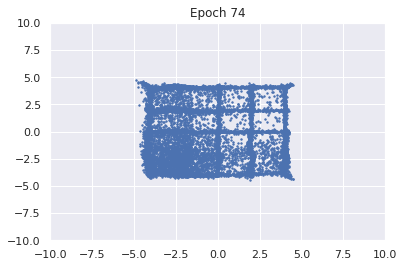

100%|██████████| 976/976 [00:07<00:00, 128.97it/s]


D loss : 1.3356, GP_loss : 0.0 G_loss : -0.7672, MI : 0.3465


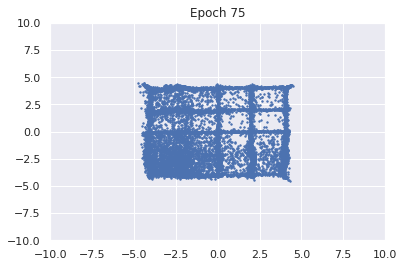

100%|██████████| 976/976 [00:07<00:00, 128.07it/s]


D loss : 1.3362, GP_loss : 0.0 G_loss : -0.7687, MI : 0.353


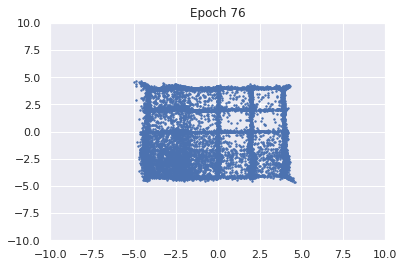

100%|██████████| 976/976 [00:07<00:00, 123.39it/s]


D loss : 1.3377, GP_loss : 0.0 G_loss : -0.7686, MI : 0.3551


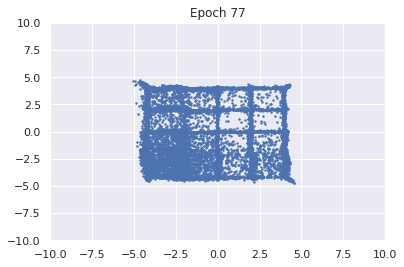

100%|██████████| 976/976 [00:08<00:00, 121.77it/s]


D loss : 1.3401, GP_loss : 0.0 G_loss : -0.768, MI : 0.3561


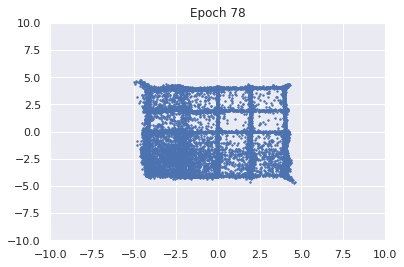

100%|██████████| 976/976 [00:07<00:00, 124.34it/s]


D loss : 1.3416, GP_loss : 0.0 G_loss : -0.767, MI : 0.3541


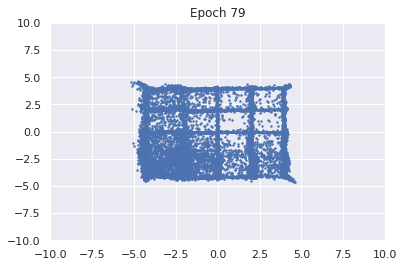

100%|██████████| 976/976 [00:07<00:00, 123.61it/s]


D loss : 1.3435, GP_loss : 0.0 G_loss : -0.7666, MI : 0.3592


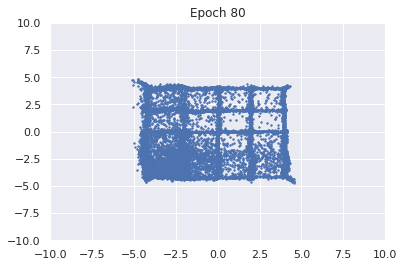

100%|██████████| 976/976 [00:07<00:00, 122.19it/s]


D loss : 1.3445, GP_loss : 0.0 G_loss : -0.7669, MI : 0.3584


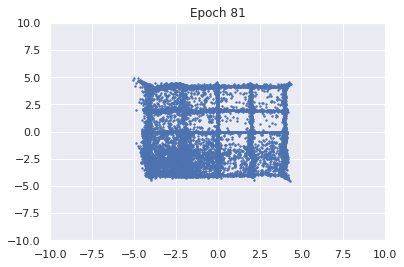

100%|██████████| 976/976 [00:07<00:00, 122.62it/s]


D loss : 1.3469, GP_loss : 0.0 G_loss : -0.7663, MI : 0.359


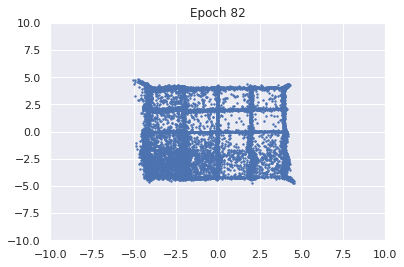

100%|██████████| 976/976 [00:07<00:00, 122.06it/s]


D loss : 1.3479, GP_loss : 0.0 G_loss : -0.7658, MI : 0.3573


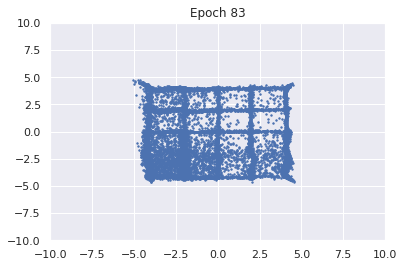

100%|██████████| 976/976 [00:07<00:00, 125.45it/s]


D loss : 1.3505, GP_loss : 0.0 G_loss : -0.7651, MI : 0.3629


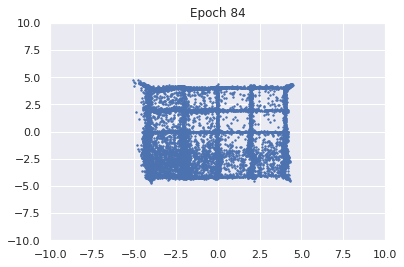

100%|██████████| 976/976 [00:07<00:00, 122.72it/s]


D loss : 1.3506, GP_loss : 0.0 G_loss : -0.7646, MI : 0.3603


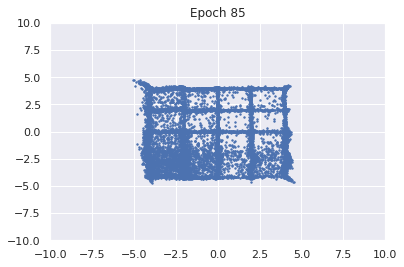

100%|██████████| 976/976 [00:07<00:00, 123.04it/s]


D loss : 1.3526, GP_loss : 0.0 G_loss : -0.7634, MI : 0.3537


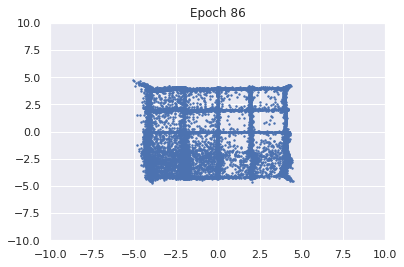

100%|██████████| 976/976 [00:07<00:00, 124.26it/s]


D loss : 1.3534, GP_loss : 0.0 G_loss : -0.7635, MI : 0.3509


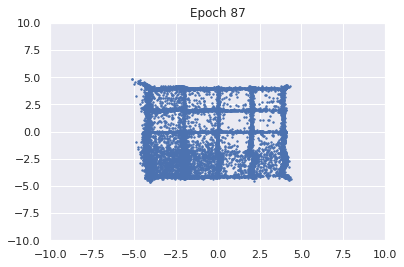

100%|██████████| 976/976 [00:07<00:00, 123.73it/s]


D loss : 1.3541, GP_loss : 0.0 G_loss : -0.7636, MI : 0.351


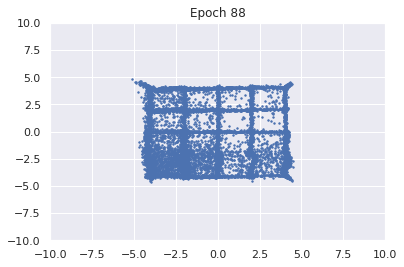

100%|██████████| 976/976 [00:07<00:00, 123.35it/s]


D loss : 1.3555, GP_loss : 0.0 G_loss : -0.7617, MI : 0.3512


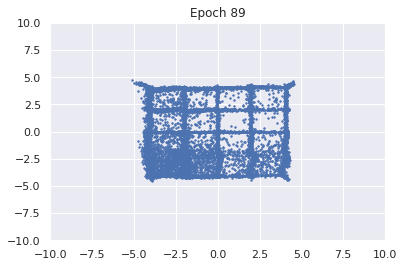

100%|██████████| 976/976 [00:07<00:00, 124.12it/s]


D loss : 1.3568, GP_loss : 0.0 G_loss : -0.761, MI : 0.3543


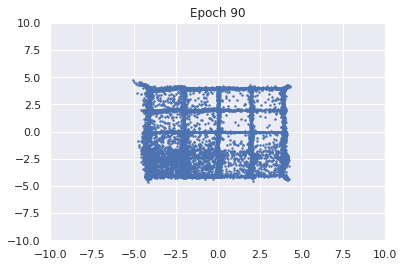

100%|██████████| 976/976 [00:08<00:00, 120.05it/s]


D loss : 1.3575, GP_loss : 0.0 G_loss : -0.7604, MI : 0.352


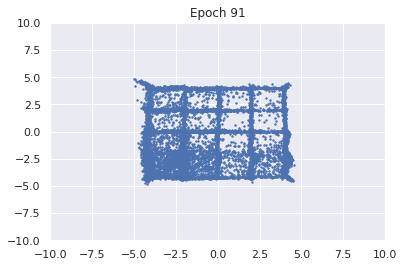

100%|██████████| 976/976 [00:07<00:00, 123.39it/s]


D loss : 1.3577, GP_loss : 0.0 G_loss : -0.761, MI : 0.3539


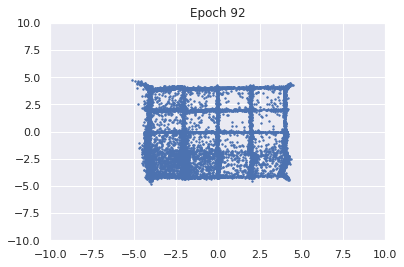

100%|██████████| 976/976 [00:08<00:00, 121.88it/s]


D loss : 1.3588, GP_loss : 0.0 G_loss : -0.7602, MI : 0.3561


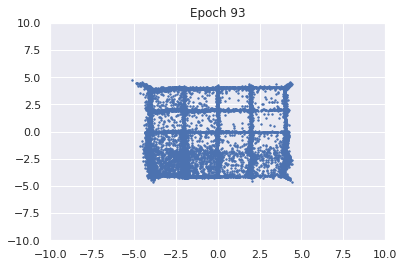

100%|██████████| 976/976 [00:07<00:00, 123.49it/s]


D loss : 1.3598, GP_loss : 0.0 G_loss : -0.7602, MI : 0.3527


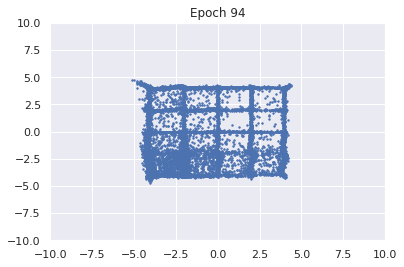

100%|██████████| 976/976 [00:08<00:00, 116.15it/s]


D loss : 1.3604, GP_loss : 0.0 G_loss : -0.7607, MI : 0.3572


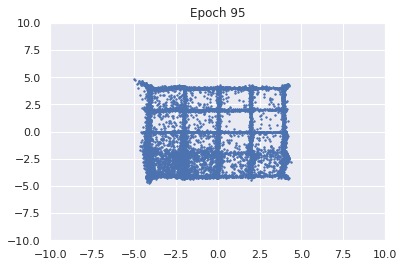

100%|██████████| 976/976 [00:08<00:00, 121.44it/s]


D loss : 1.3621, GP_loss : 0.0 G_loss : -0.7594, MI : 0.3461


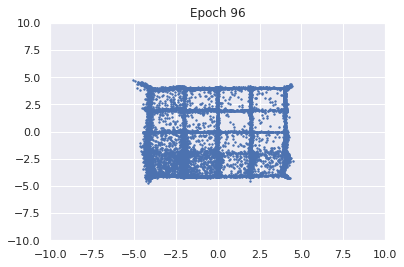

100%|██████████| 976/976 [00:07<00:00, 122.91it/s]


D loss : 1.362, GP_loss : 0.0 G_loss : -0.7596, MI : 0.3506


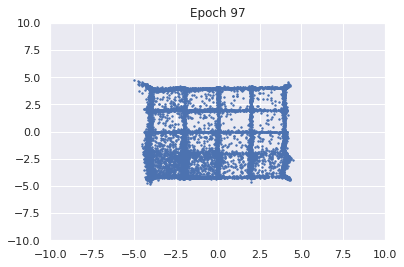

100%|██████████| 976/976 [00:07<00:00, 123.18it/s]


D loss : 1.3637, GP_loss : 0.0 G_loss : -0.7582, MI : 0.3509


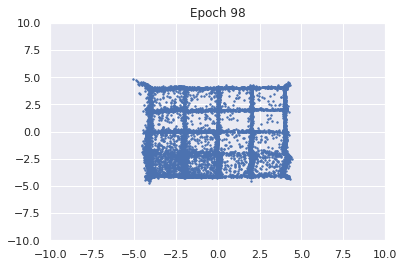

100%|██████████| 976/976 [00:07<00:00, 123.42it/s]


D loss : 1.3641, GP_loss : 0.0 G_loss : -0.7593, MI : 0.3514


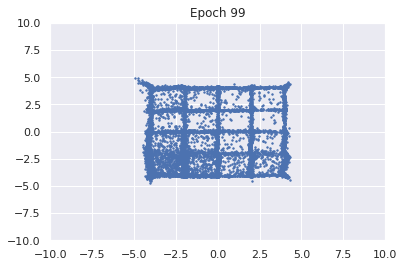

100%|██████████| 976/976 [00:07<00:00, 122.84it/s]


D loss : 1.3651, GP_loss : 0.0 G_loss : -0.7574, MI : 0.3531


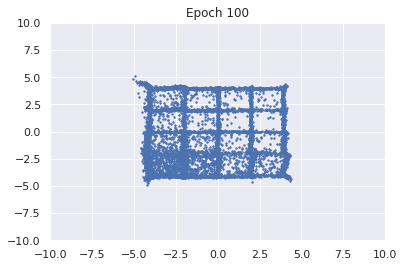

100%|██████████| 976/976 [00:07<00:00, 122.49it/s]


D loss : 1.3668, GP_loss : 0.0 G_loss : -0.7563, MI : 0.3516


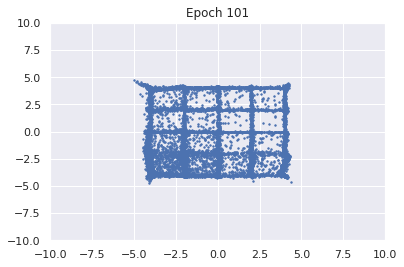

100%|██████████| 976/976 [00:07<00:00, 123.22it/s]


D loss : 1.3675, GP_loss : 0.0 G_loss : -0.7554, MI : 0.3552


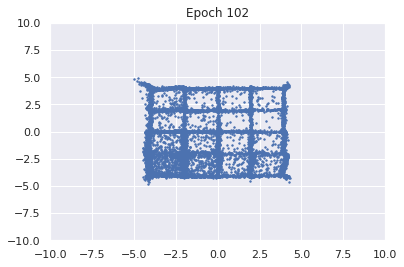

100%|██████████| 976/976 [00:07<00:00, 123.43it/s]


D loss : 1.3684, GP_loss : 0.0 G_loss : -0.7547, MI : 0.3512


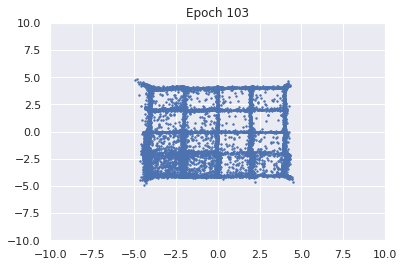

100%|██████████| 976/976 [00:07<00:00, 124.25it/s]


D loss : 1.3687, GP_loss : 0.0 G_loss : -0.7549, MI : 0.3548


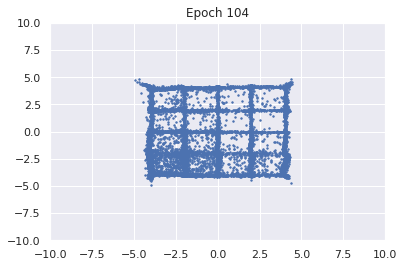

100%|██████████| 976/976 [00:07<00:00, 122.23it/s]


D loss : 1.3696, GP_loss : 0.0 G_loss : -0.754, MI : 0.3529


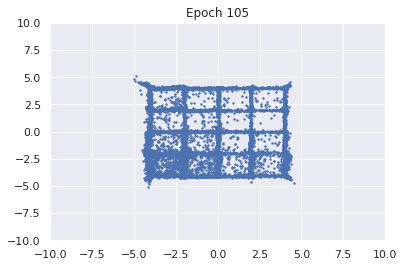

100%|██████████| 976/976 [00:07<00:00, 122.68it/s]


D loss : 1.3704, GP_loss : 0.0 G_loss : -0.7535, MI : 0.3569


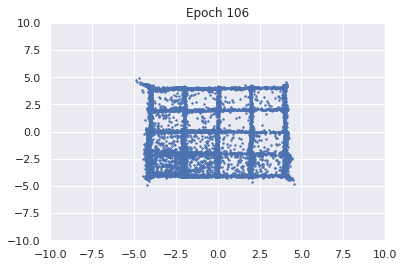

100%|██████████| 976/976 [00:07<00:00, 122.21it/s]


D loss : 1.3714, GP_loss : 0.0 G_loss : -0.7516, MI : 0.3561


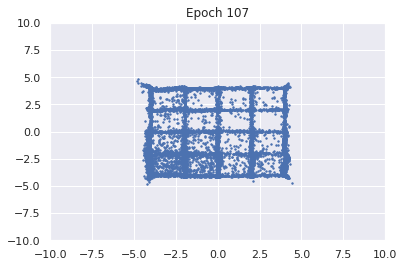

100%|██████████| 976/976 [00:07<00:00, 123.96it/s]


D loss : 1.3718, GP_loss : 0.0 G_loss : -0.7508, MI : 0.3559


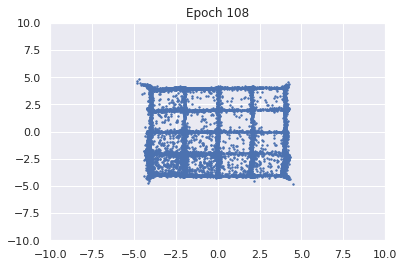

100%|██████████| 976/976 [00:07<00:00, 123.76it/s]


D loss : 1.3723, GP_loss : 0.0 G_loss : -0.7506, MI : 0.3535


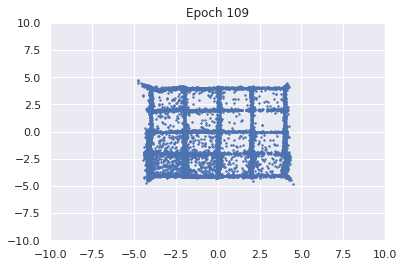

100%|██████████| 976/976 [00:07<00:00, 123.18it/s]


D loss : 1.3728, GP_loss : 0.0 G_loss : -0.7499, MI : 0.3531


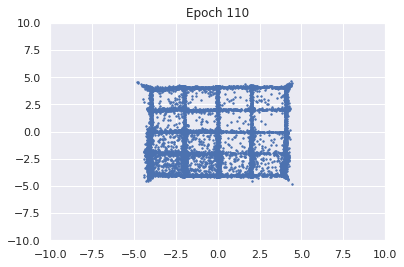

100%|██████████| 976/976 [00:07<00:00, 123.22it/s]


D loss : 1.3734, GP_loss : 0.0 G_loss : -0.7493, MI : 0.3567


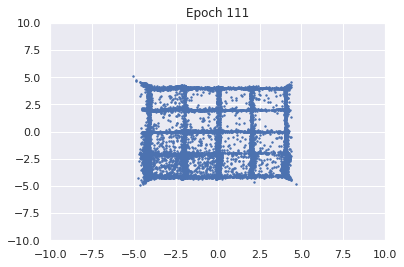

100%|██████████| 976/976 [00:07<00:00, 124.23it/s]


D loss : 1.374, GP_loss : 0.0 G_loss : -0.7478, MI : 0.3534


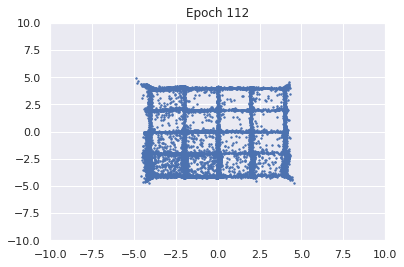

100%|██████████| 976/976 [00:07<00:00, 125.01it/s]


D loss : 1.3743, GP_loss : 0.0 G_loss : -0.7476, MI : 0.3533


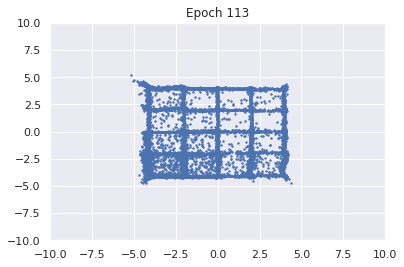

100%|██████████| 976/976 [00:07<00:00, 125.68it/s]


D loss : 1.3747, GP_loss : 0.0 G_loss : -0.7465, MI : 0.3488


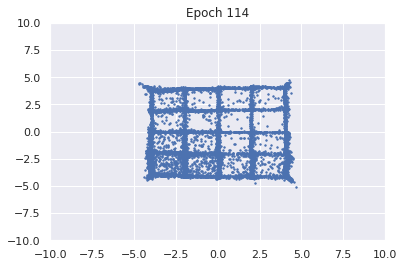

100%|██████████| 976/976 [00:07<00:00, 124.20it/s]


D loss : 1.3754, GP_loss : 0.0 G_loss : -0.7465, MI : 0.3539


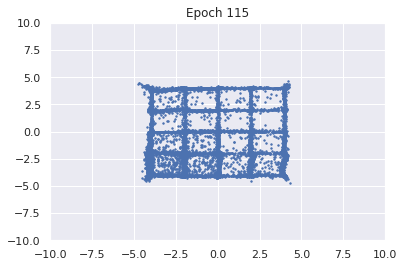

100%|██████████| 976/976 [00:07<00:00, 124.22it/s]


D loss : 1.3757, GP_loss : 0.0 G_loss : -0.7451, MI : 0.3475


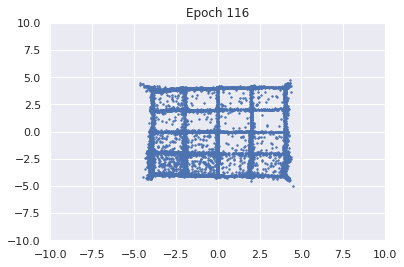

100%|██████████| 976/976 [00:07<00:00, 122.67it/s]


D loss : 1.3759, GP_loss : 0.0 G_loss : -0.746, MI : 0.3465


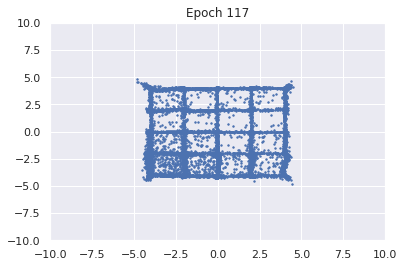

100%|██████████| 976/976 [00:07<00:00, 123.53it/s]


D loss : 1.3762, GP_loss : 0.0 G_loss : -0.7451, MI : 0.3463


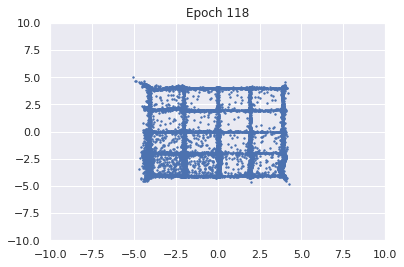

100%|██████████| 976/976 [00:07<00:00, 128.14it/s]


D loss : 1.3768, GP_loss : 0.0 G_loss : -0.7433, MI : 0.3521


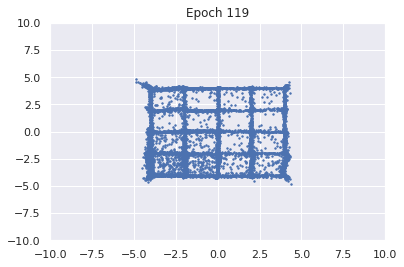

100%|██████████| 976/976 [00:07<00:00, 129.91it/s]


D loss : 1.3767, GP_loss : 0.0 G_loss : -0.7448, MI : 0.3556


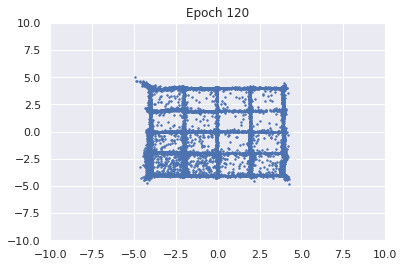

100%|██████████| 976/976 [00:07<00:00, 125.22it/s]


D loss : 1.3771, GP_loss : 0.0 G_loss : -0.7435, MI : 0.3509


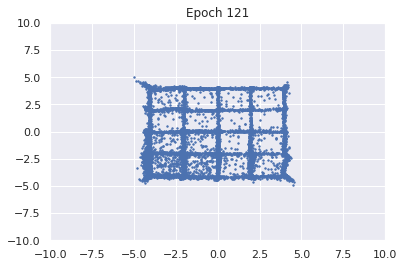

100%|██████████| 976/976 [00:07<00:00, 122.25it/s]


D loss : 1.3774, GP_loss : 0.0 G_loss : -0.7433, MI : 0.35


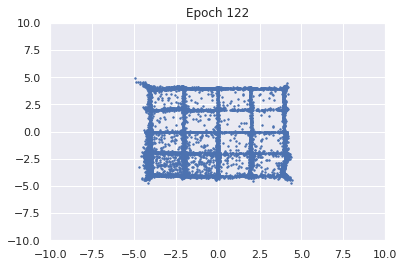

100%|██████████| 976/976 [00:07<00:00, 123.26it/s]


D loss : 1.3781, GP_loss : 0.0 G_loss : -0.7413, MI : 0.3547


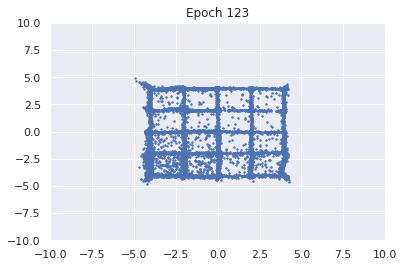

100%|██████████| 976/976 [00:07<00:00, 123.60it/s]


D loss : 1.3781, GP_loss : 0.0 G_loss : -0.7411, MI : 0.3546


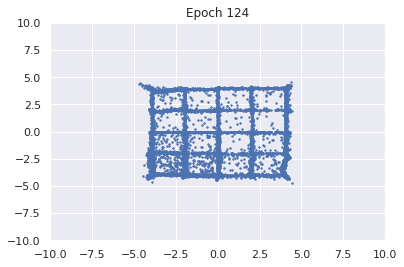

100%|██████████| 976/976 [00:07<00:00, 123.23it/s]


D loss : 1.3782, GP_loss : 0.0 G_loss : -0.7409, MI : 0.3515


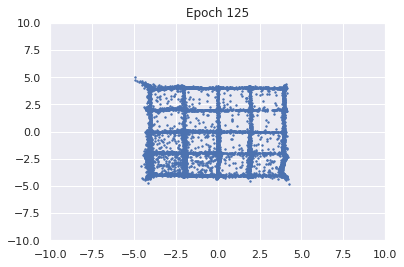

100%|██████████| 976/976 [00:07<00:00, 122.39it/s]


D loss : 1.3785, GP_loss : 0.0 G_loss : -0.7402, MI : 0.3496


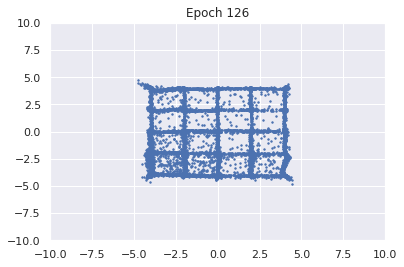

100%|██████████| 976/976 [00:07<00:00, 123.90it/s]


D loss : 1.379, GP_loss : 0.0 G_loss : -0.7389, MI : 0.3538


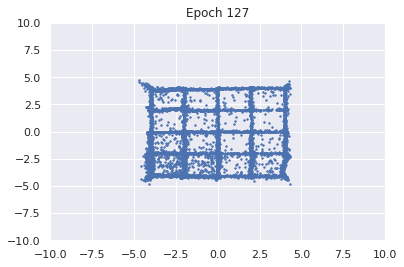

100%|██████████| 976/976 [00:07<00:00, 124.76it/s]


D loss : 1.3791, GP_loss : 0.0 G_loss : -0.739, MI : 0.3556


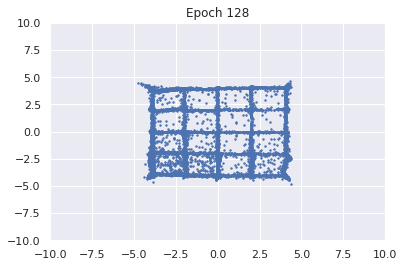

100%|██████████| 976/976 [00:07<00:00, 122.05it/s]


D loss : 1.3792, GP_loss : 0.0 G_loss : -0.7394, MI : 0.3557


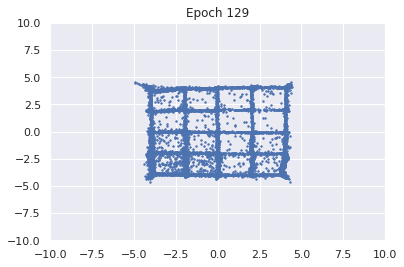

100%|██████████| 976/976 [00:07<00:00, 122.48it/s]


D loss : 1.3793, GP_loss : 0.0 G_loss : -0.7389, MI : 0.352


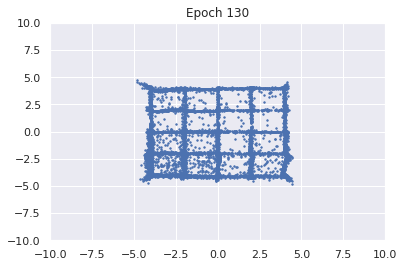

100%|██████████| 976/976 [00:07<00:00, 123.92it/s]


D loss : 1.3799, GP_loss : 0.0 G_loss : -0.7366, MI : 0.355


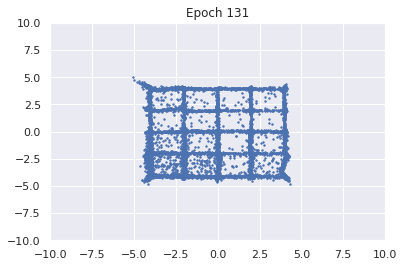

100%|██████████| 976/976 [00:07<00:00, 124.34it/s]


D loss : 1.3799, GP_loss : 0.0 G_loss : -0.7344, MI : 0.3537


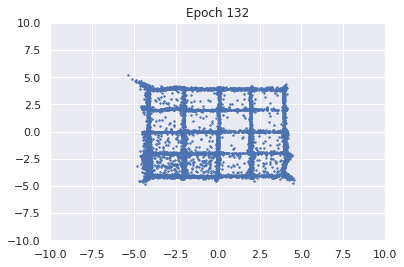

100%|██████████| 976/976 [00:07<00:00, 124.99it/s]


D loss : 1.3799, GP_loss : 0.0 G_loss : -0.7365, MI : 0.3562


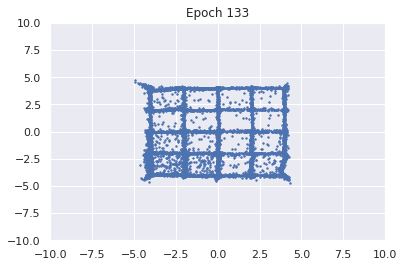

100%|██████████| 976/976 [00:07<00:00, 123.21it/s]


D loss : 1.3801, GP_loss : 0.0 G_loss : -0.7352, MI : 0.3625


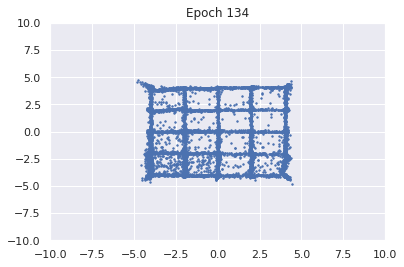

100%|██████████| 976/976 [00:07<00:00, 123.32it/s]


D loss : 1.3802, GP_loss : 0.0 G_loss : -0.7353, MI : 0.3565


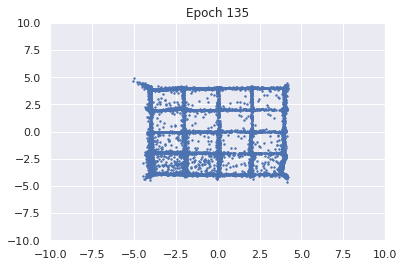

100%|██████████| 976/976 [00:07<00:00, 123.92it/s]


D loss : 1.3805, GP_loss : 0.0 G_loss : -0.7346, MI : 0.3557


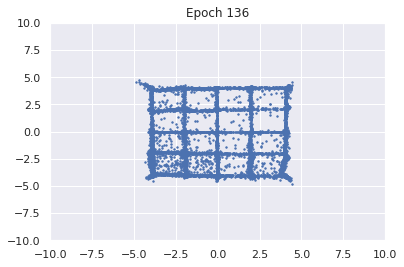

100%|██████████| 976/976 [00:07<00:00, 123.12it/s]


D loss : 1.3805, GP_loss : 0.0 G_loss : -0.7352, MI : 0.3573


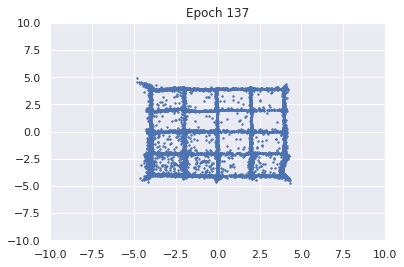

100%|██████████| 976/976 [00:07<00:00, 123.31it/s]


D loss : 1.381, GP_loss : 0.0 G_loss : -0.7316, MI : 0.3586


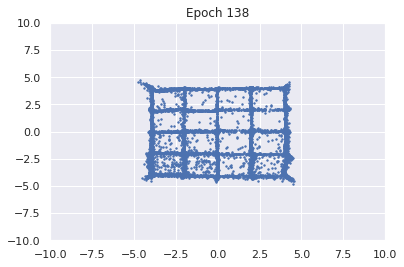

100%|██████████| 976/976 [00:08<00:00, 121.93it/s]


D loss : 1.3807, GP_loss : 0.0 G_loss : -0.7337, MI : 0.3621


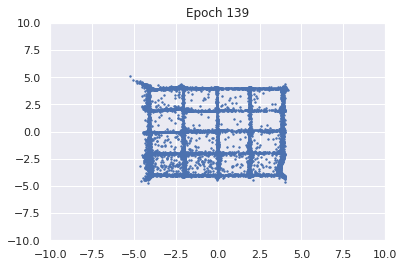

100%|██████████| 976/976 [00:07<00:00, 125.19it/s]


D loss : 1.381, GP_loss : 0.0 G_loss : -0.7319, MI : 0.359


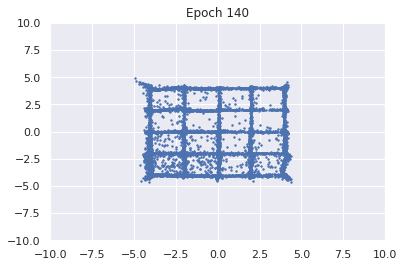

100%|██████████| 976/976 [00:08<00:00, 121.52it/s]


D loss : 1.3808, GP_loss : 0.0 G_loss : -0.7348, MI : 0.3629


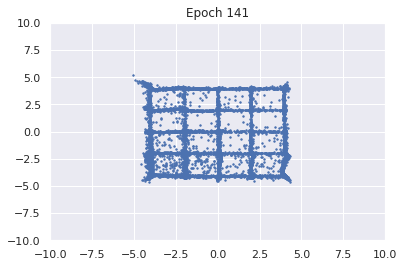

100%|██████████| 976/976 [00:07<00:00, 124.82it/s]


D loss : 1.381, GP_loss : 0.0 G_loss : -0.7324, MI : 0.3581


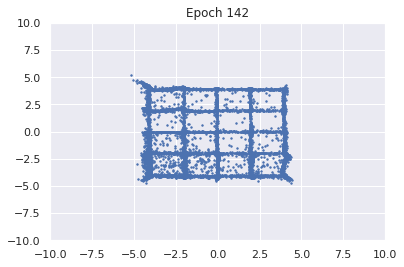

100%|██████████| 976/976 [00:07<00:00, 123.52it/s]


D loss : 1.3815, GP_loss : 0.0 G_loss : -0.7312, MI : 0.3583


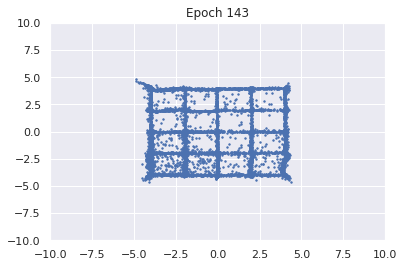

100%|██████████| 976/976 [00:07<00:00, 123.19it/s]


D loss : 1.3815, GP_loss : 0.0 G_loss : -0.7314, MI : 0.3533


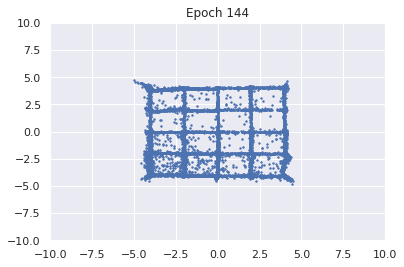

100%|██████████| 976/976 [00:07<00:00, 122.23it/s]


D loss : 1.3814, GP_loss : 0.0 G_loss : -0.7311, MI : 0.358


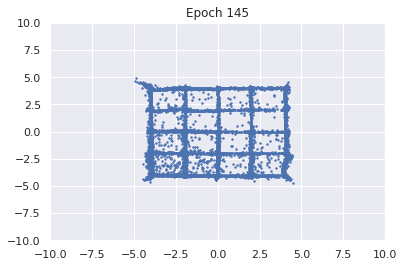

100%|██████████| 976/976 [00:07<00:00, 122.76it/s]


D loss : 1.3815, GP_loss : 0.0 G_loss : -0.7318, MI : 0.3521


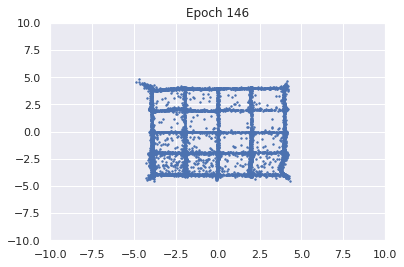

100%|██████████| 976/976 [00:07<00:00, 127.53it/s]


D loss : 1.3817, GP_loss : 0.0 G_loss : -0.73, MI : 0.3576


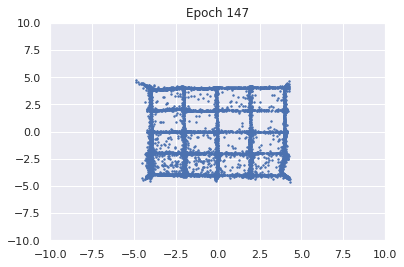

100%|██████████| 976/976 [00:07<00:00, 121.98it/s]


D loss : 1.3817, GP_loss : 0.0 G_loss : -0.7293, MI : 0.3559


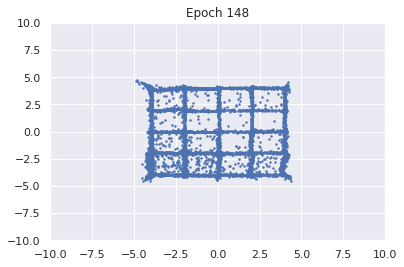

100%|██████████| 976/976 [00:07<00:00, 127.17it/s]


D loss : 1.3818, GP_loss : 0.0 G_loss : -0.7285, MI : 0.3572


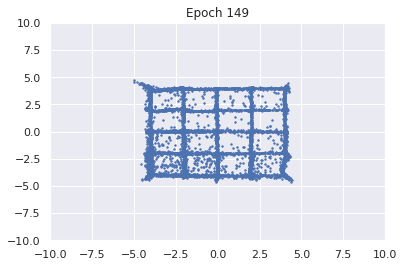

100%|██████████| 976/976 [00:07<00:00, 124.03it/s]


D loss : 1.3822, GP_loss : 0.0 G_loss : -0.7282, MI : 0.3576


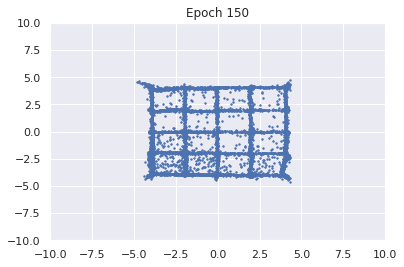

100%|██████████| 976/976 [00:07<00:00, 122.39it/s]


D loss : 1.3822, GP_loss : 0.0 G_loss : -0.7277, MI : 0.3555


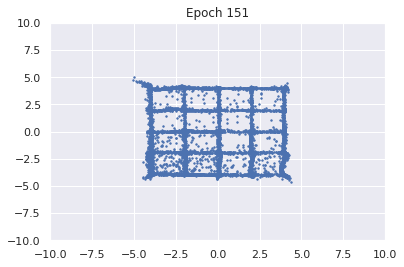

100%|██████████| 976/976 [00:07<00:00, 123.37it/s]


D loss : 1.3823, GP_loss : 0.0 G_loss : -0.726, MI : 0.3512


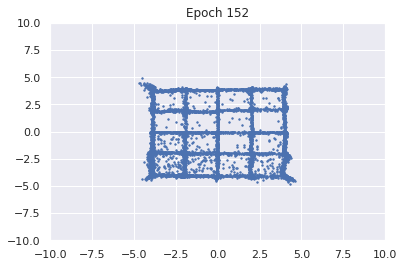

100%|██████████| 976/976 [00:07<00:00, 123.61it/s]


D loss : 1.3823, GP_loss : 0.0 G_loss : -0.7275, MI : 0.3539


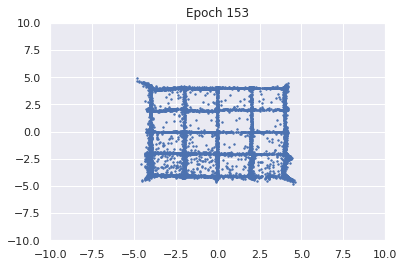

100%|██████████| 976/976 [00:07<00:00, 123.32it/s]


D loss : 1.3824, GP_loss : 0.0 G_loss : -0.7277, MI : 0.352


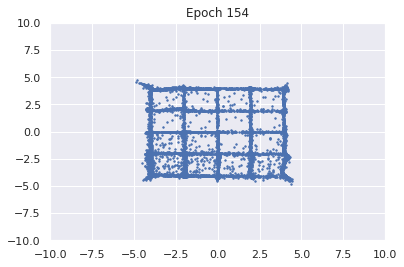

100%|██████████| 976/976 [00:07<00:00, 123.25it/s]


D loss : 1.3822, GP_loss : 0.0 G_loss : -0.7287, MI : 0.3492


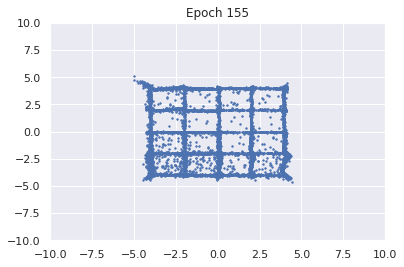

100%|██████████| 976/976 [00:07<00:00, 122.24it/s]


D loss : 1.3823, GP_loss : 0.0 G_loss : -0.7289, MI : 0.355


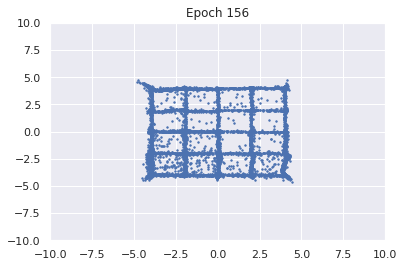

100%|██████████| 976/976 [00:07<00:00, 122.92it/s]


D loss : 1.3823, GP_loss : 0.0 G_loss : -0.7279, MI : 0.3513


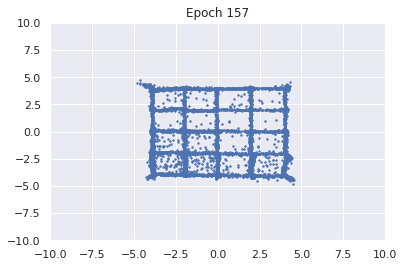

100%|██████████| 976/976 [00:07<00:00, 124.01it/s]


D loss : 1.3827, GP_loss : 0.0 G_loss : -0.725, MI : 0.3572


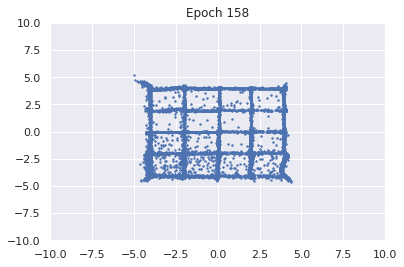

100%|██████████| 976/976 [00:07<00:00, 124.05it/s]


D loss : 1.3825, GP_loss : 0.0 G_loss : -0.7264, MI : 0.3528


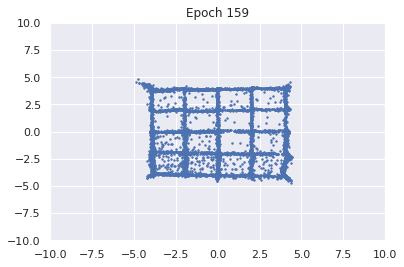

100%|██████████| 976/976 [00:07<00:00, 122.97it/s]


D loss : 1.3827, GP_loss : 0.0 G_loss : -0.7251, MI : 0.3569


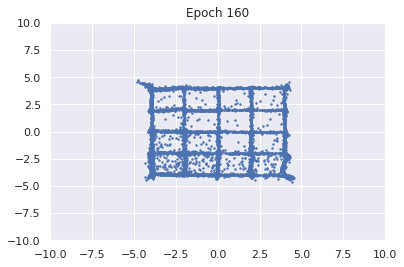

100%|██████████| 976/976 [00:07<00:00, 124.01it/s]


D loss : 1.3827, GP_loss : 0.0 G_loss : -0.7243, MI : 0.3559


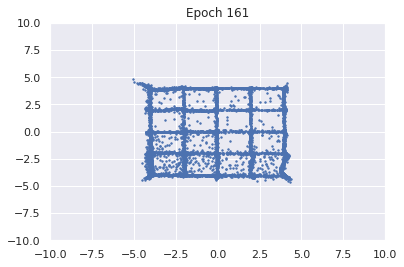

100%|██████████| 976/976 [00:07<00:00, 123.36it/s]


D loss : 1.3829, GP_loss : 0.0 G_loss : -0.7235, MI : 0.3598


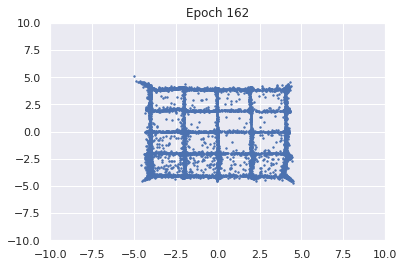

100%|██████████| 976/976 [00:07<00:00, 122.99it/s]


D loss : 1.3828, GP_loss : 0.0 G_loss : -0.7252, MI : 0.355


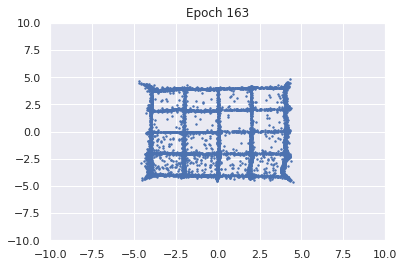

100%|██████████| 976/976 [00:07<00:00, 124.17it/s]


D loss : 1.3829, GP_loss : 0.0 G_loss : -0.7244, MI : 0.3568


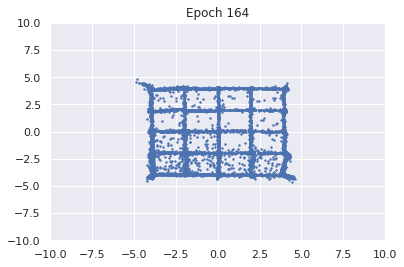

100%|██████████| 976/976 [00:07<00:00, 123.71it/s]


D loss : 1.3827, GP_loss : 0.0 G_loss : -0.7261, MI : 0.3544


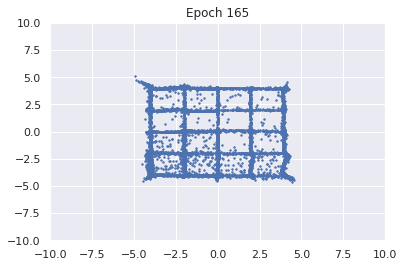

100%|██████████| 976/976 [00:07<00:00, 123.03it/s]


D loss : 1.383, GP_loss : 0.0 G_loss : -0.722, MI : 0.3553


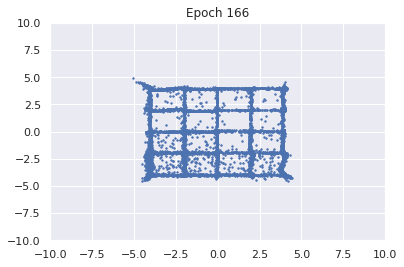

100%|██████████| 976/976 [00:07<00:00, 123.79it/s]


D loss : 1.3828, GP_loss : 0.0 G_loss : -0.7245, MI : 0.3538


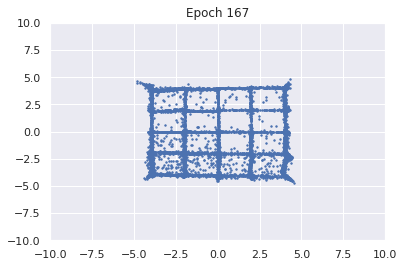

100%|██████████| 976/976 [00:07<00:00, 122.92it/s]


D loss : 1.3831, GP_loss : 0.0 G_loss : -0.7233, MI : 0.3522


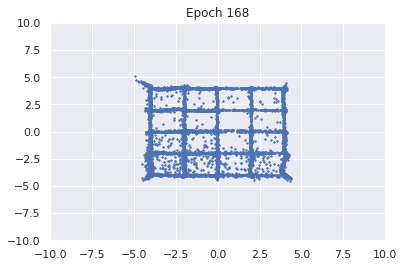

100%|██████████| 976/976 [00:07<00:00, 122.40it/s]


D loss : 1.3832, GP_loss : 0.0 G_loss : -0.7219, MI : 0.3498


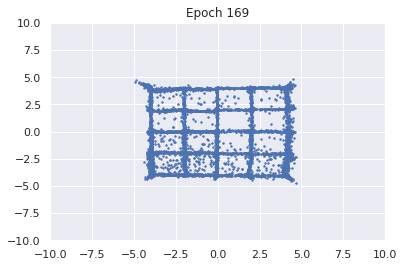

100%|██████████| 976/976 [00:07<00:00, 122.27it/s]


D loss : 1.383, GP_loss : 0.0 G_loss : -0.7236, MI : 0.3523


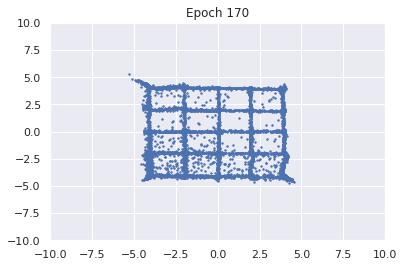

100%|██████████| 976/976 [00:07<00:00, 123.97it/s]


D loss : 1.3832, GP_loss : 0.0 G_loss : -0.7227, MI : 0.3552


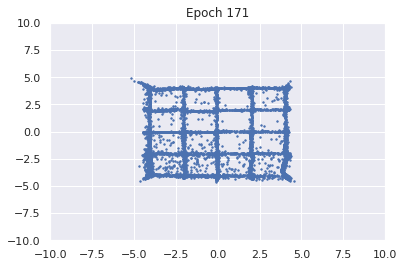

100%|██████████| 976/976 [00:07<00:00, 122.90it/s]


D loss : 1.3832, GP_loss : 0.0 G_loss : -0.7219, MI : 0.3558


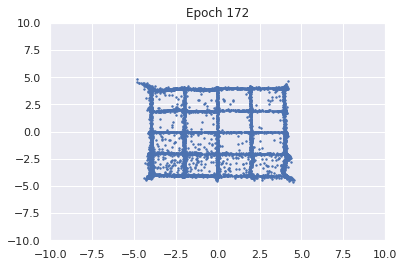

100%|██████████| 976/976 [00:07<00:00, 122.80it/s]


D loss : 1.3834, GP_loss : 0.0 G_loss : -0.7203, MI : 0.3512


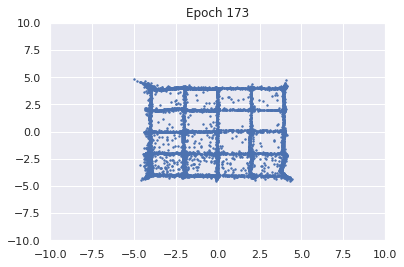

100%|██████████| 976/976 [00:07<00:00, 123.88it/s]


D loss : 1.3834, GP_loss : 0.0 G_loss : -0.7198, MI : 0.3514


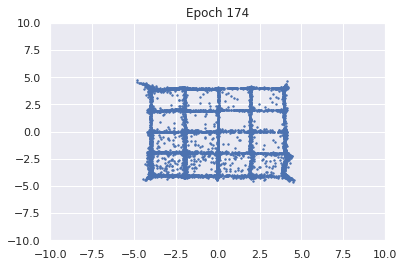

100%|██████████| 976/976 [00:07<00:00, 124.15it/s]


D loss : 1.3835, GP_loss : 0.0 G_loss : -0.7188, MI : 0.3585


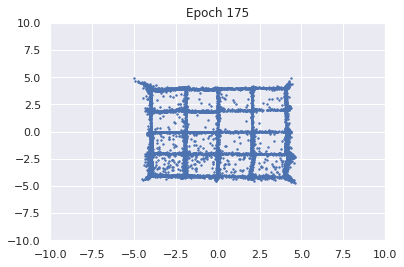

100%|██████████| 976/976 [00:07<00:00, 123.17it/s]


D loss : 1.3834, GP_loss : 0.0 G_loss : -0.7208, MI : 0.3542


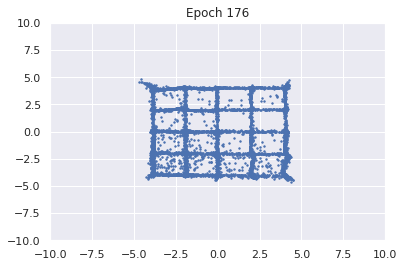

100%|██████████| 976/976 [00:07<00:00, 123.25it/s]


D loss : 1.3836, GP_loss : 0.0 G_loss : -0.7196, MI : 0.3539


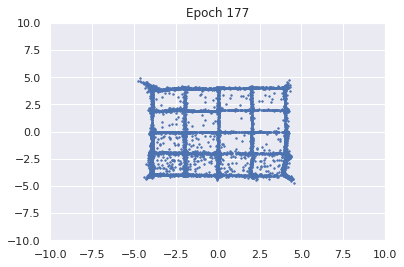

100%|██████████| 976/976 [00:07<00:00, 122.54it/s]


D loss : 1.3835, GP_loss : 0.0 G_loss : -0.7211, MI : 0.3548


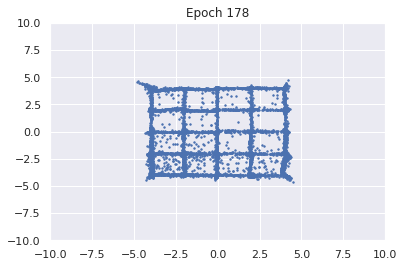

100%|██████████| 976/976 [00:07<00:00, 122.20it/s]


D loss : 1.3836, GP_loss : 0.0 G_loss : -0.7196, MI : 0.3533


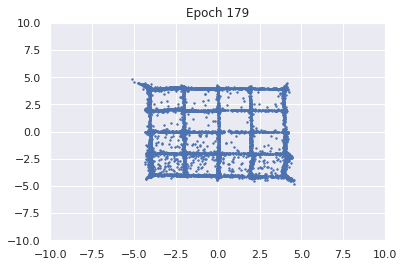

100%|██████████| 976/976 [00:07<00:00, 122.02it/s]


D loss : 1.3833, GP_loss : 0.0 G_loss : -0.7218, MI : 0.3602


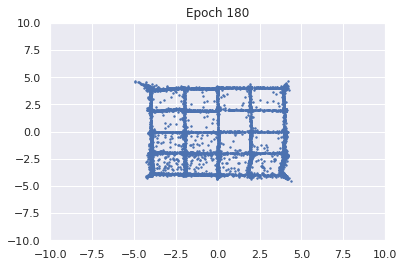

100%|██████████| 976/976 [00:07<00:00, 123.51it/s]


D loss : 1.3832, GP_loss : 0.0 G_loss : -0.7216, MI : 0.3558


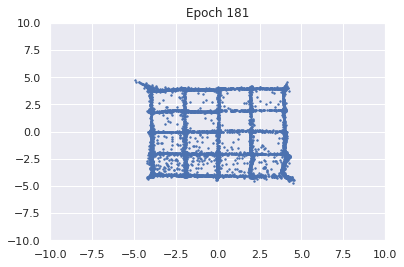

100%|██████████| 976/976 [00:07<00:00, 124.11it/s]


D loss : 1.3837, GP_loss : 0.0 G_loss : -0.7178, MI : 0.3598


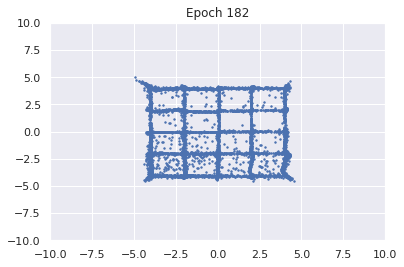

100%|██████████| 976/976 [00:07<00:00, 124.94it/s]


D loss : 1.3835, GP_loss : 0.0 G_loss : -0.7192, MI : 0.3549


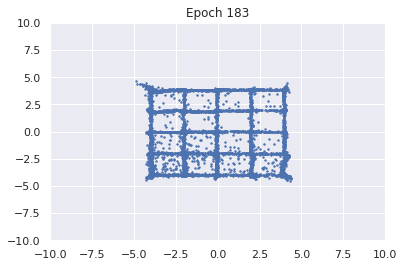

100%|██████████| 976/976 [00:07<00:00, 125.45it/s]


D loss : 1.3836, GP_loss : 0.0 G_loss : -0.7183, MI : 0.3528


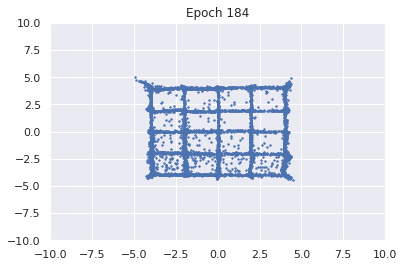

100%|██████████| 976/976 [00:08<00:00, 121.60it/s]


D loss : 1.3838, GP_loss : 0.0 G_loss : -0.7165, MI : 0.3544


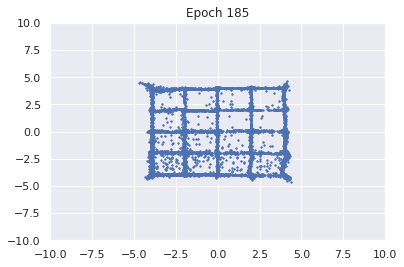

100%|██████████| 976/976 [00:07<00:00, 122.21it/s]


D loss : 1.3837, GP_loss : 0.0 G_loss : -0.7156, MI : 0.3499


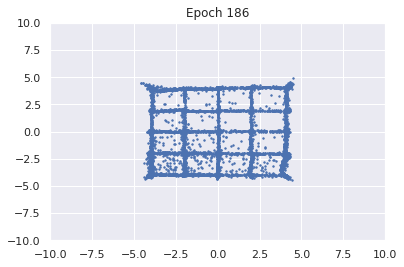

100%|██████████| 976/976 [00:07<00:00, 123.98it/s]


D loss : 1.3836, GP_loss : 0.0 G_loss : -0.7179, MI : 0.3562


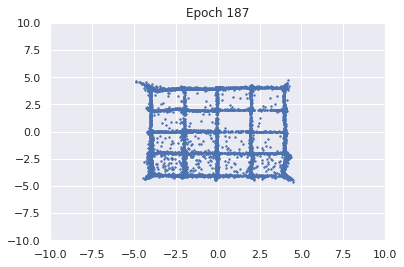

100%|██████████| 976/976 [00:07<00:00, 125.33it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7158, MI : 0.3541


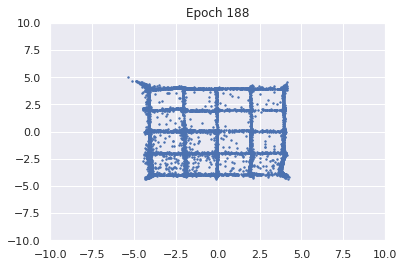

100%|██████████| 976/976 [00:07<00:00, 124.00it/s]


D loss : 1.3837, GP_loss : 0.0 G_loss : -0.7189, MI : 0.3545


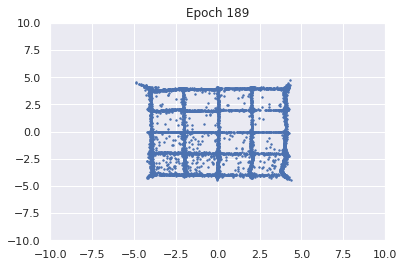

100%|██████████| 976/976 [00:07<00:00, 125.98it/s]


D loss : 1.3838, GP_loss : 0.0 G_loss : -0.7188, MI : 0.3561


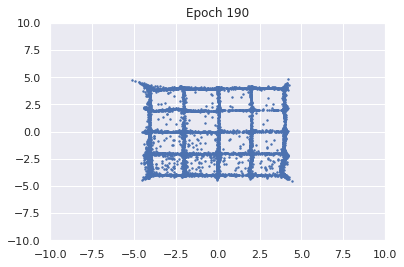

100%|██████████| 976/976 [00:07<00:00, 122.16it/s]


D loss : 1.3837, GP_loss : 0.0 G_loss : -0.7178, MI : 0.3578


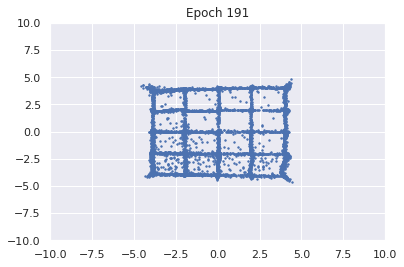

100%|██████████| 976/976 [00:07<00:00, 122.63it/s]


D loss : 1.3839, GP_loss : 0.0 G_loss : -0.7166, MI : 0.3557


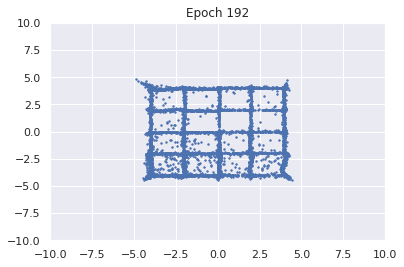

100%|██████████| 976/976 [00:07<00:00, 123.56it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.713, MI : 0.3578


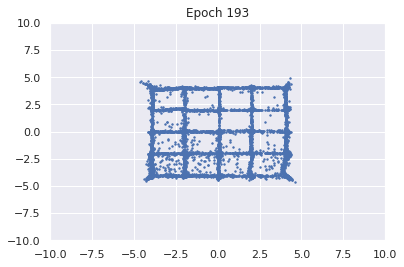

100%|██████████| 976/976 [00:07<00:00, 122.43it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7158, MI : 0.3554


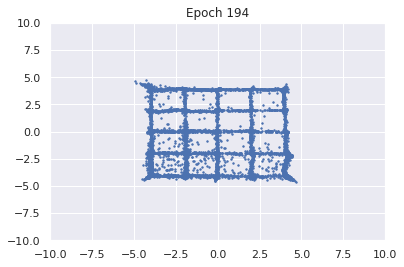

100%|██████████| 976/976 [00:07<00:00, 125.83it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.7151, MI : 0.3592


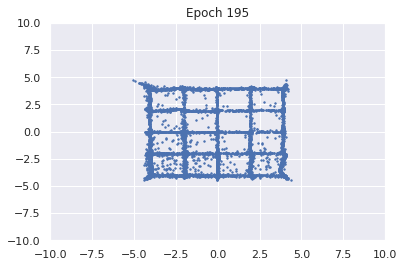

100%|██████████| 976/976 [00:07<00:00, 127.62it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7145, MI : 0.3542


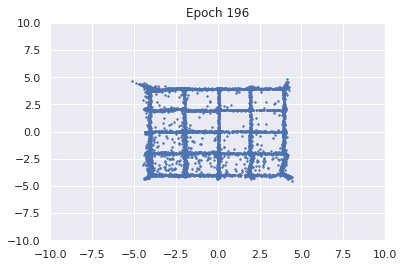

100%|██████████| 976/976 [00:07<00:00, 129.99it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.7143, MI : 0.3486


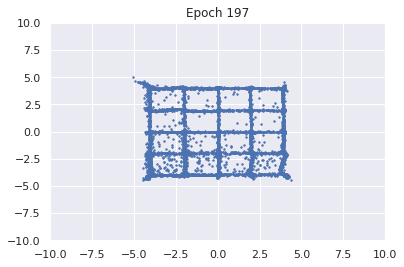

100%|██████████| 976/976 [00:07<00:00, 125.30it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.714, MI : 0.356


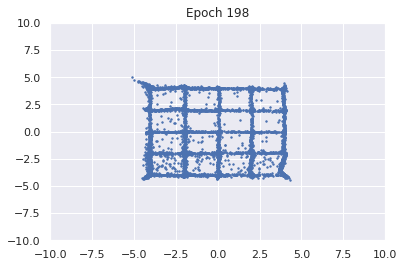

100%|██████████| 976/976 [00:07<00:00, 123.53it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.7148, MI : 0.3511


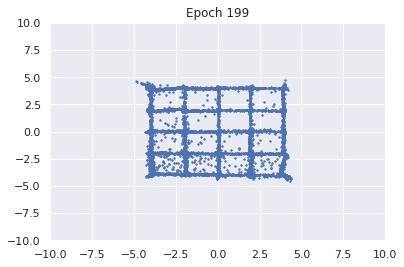

100%|██████████| 976/976 [00:07<00:00, 124.33it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7126, MI : 0.3562


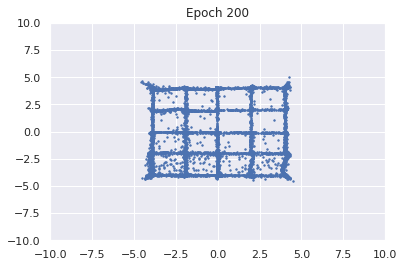

100%|██████████| 976/976 [00:07<00:00, 122.31it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.715, MI : 0.3553


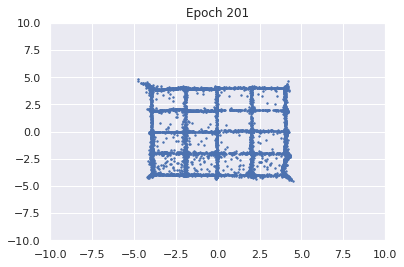

100%|██████████| 976/976 [00:07<00:00, 124.96it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7112, MI : 0.3541


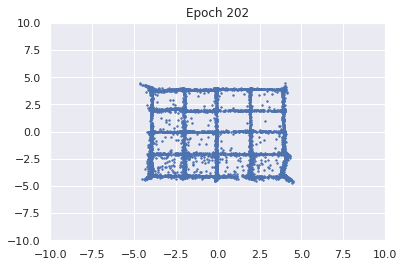

100%|██████████| 976/976 [00:07<00:00, 124.53it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7112, MI : 0.3501


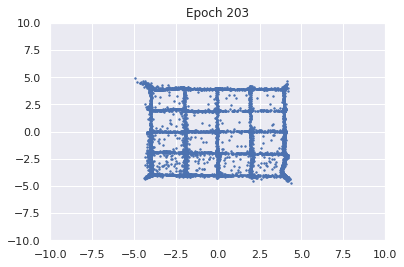

100%|██████████| 976/976 [00:07<00:00, 123.89it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7092, MI : 0.353


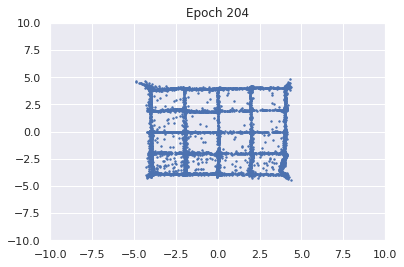

100%|██████████| 976/976 [00:07<00:00, 124.32it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.712, MI : 0.3502


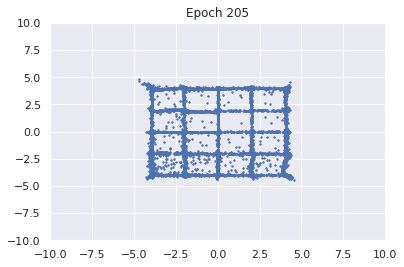

100%|██████████| 976/976 [00:07<00:00, 123.42it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.7123, MI : 0.3543


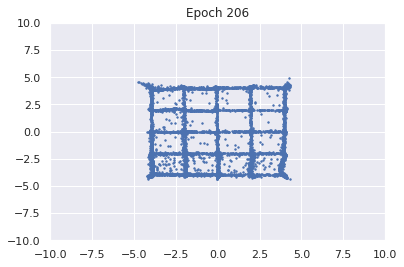

100%|██████████| 976/976 [00:07<00:00, 123.85it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7094, MI : 0.3565


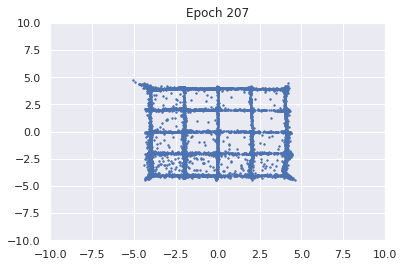

100%|██████████| 976/976 [00:07<00:00, 124.37it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7109, MI : 0.3569


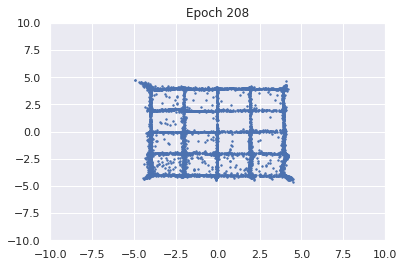

100%|██████████| 976/976 [00:07<00:00, 124.34it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7121, MI : 0.355


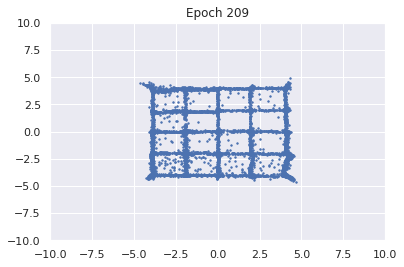

100%|██████████| 976/976 [00:07<00:00, 125.78it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7105, MI : 0.36


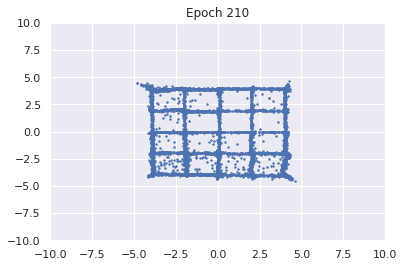

100%|██████████| 976/976 [00:07<00:00, 123.94it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.7123, MI : 0.3568


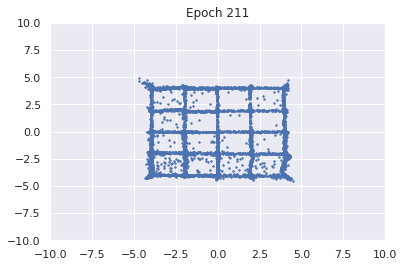

100%|██████████| 976/976 [00:07<00:00, 123.24it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7111, MI : 0.3583


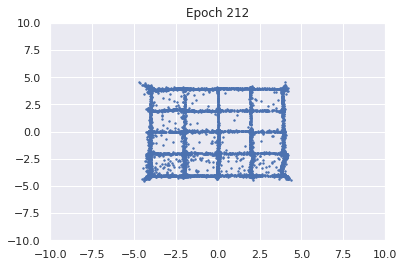

100%|██████████| 976/976 [00:07<00:00, 124.53it/s]


D loss : 1.384, GP_loss : 0.0 G_loss : -0.7117, MI : 0.3537


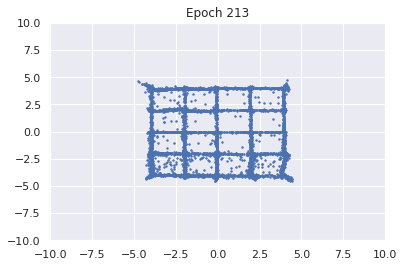

100%|██████████| 976/976 [00:07<00:00, 125.15it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7104, MI : 0.3571


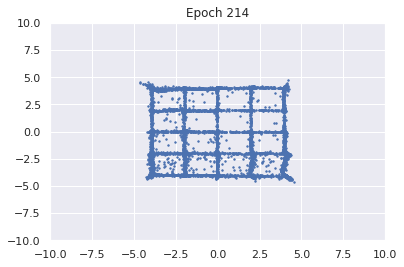

100%|██████████| 976/976 [00:07<00:00, 125.27it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7109, MI : 0.3542


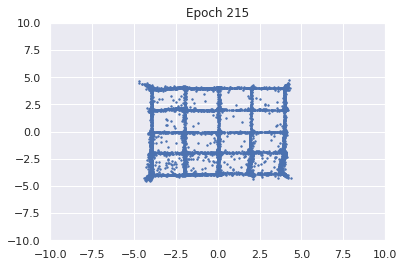

100%|██████████| 976/976 [00:07<00:00, 123.06it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7089, MI : 0.358


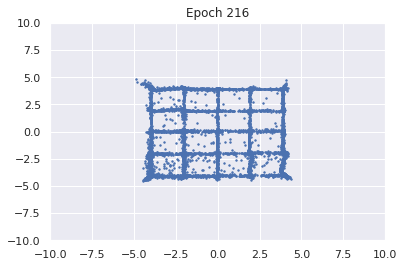

100%|██████████| 976/976 [00:07<00:00, 125.22it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7085, MI : 0.3538


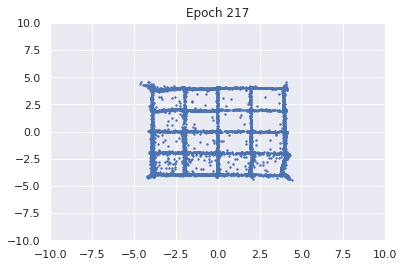

100%|██████████| 976/976 [00:07<00:00, 124.22it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7076, MI : 0.3504


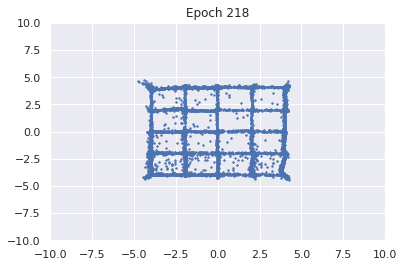

100%|██████████| 976/976 [00:07<00:00, 122.67it/s]


D loss : 1.3841, GP_loss : 0.0 G_loss : -0.7097, MI : 0.3551


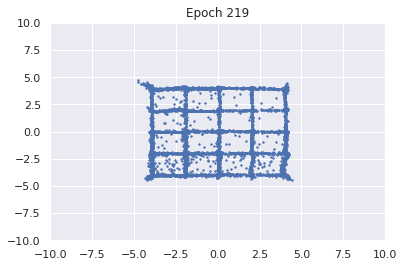

100%|██████████| 976/976 [00:07<00:00, 127.08it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7067, MI : 0.3564


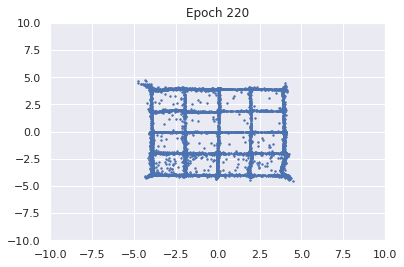

100%|██████████| 976/976 [00:07<00:00, 123.71it/s]


D loss : 1.3842, GP_loss : 0.0 G_loss : -0.7082, MI : 0.3536


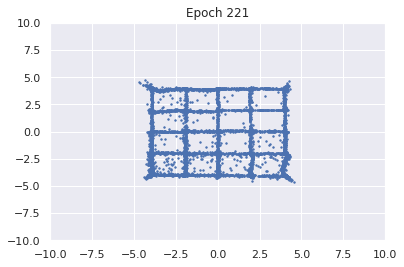

100%|██████████| 976/976 [00:07<00:00, 123.98it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7066, MI : 0.3552


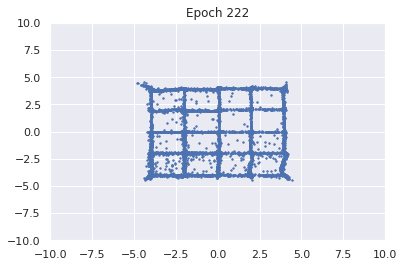

100%|██████████| 976/976 [00:07<00:00, 123.08it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.707, MI : 0.3538


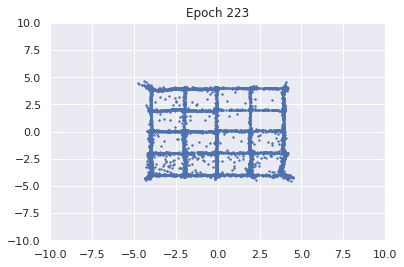

100%|██████████| 976/976 [00:07<00:00, 123.83it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7056, MI : 0.3501


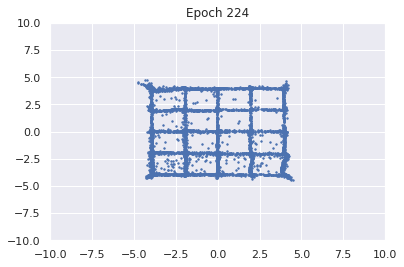

100%|██████████| 976/976 [00:07<00:00, 123.88it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7074, MI : 0.3531


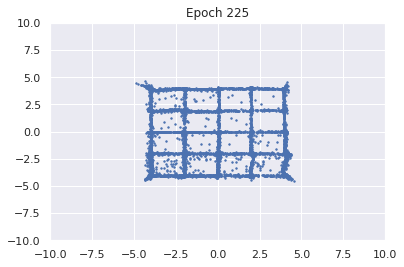

100%|██████████| 976/976 [00:07<00:00, 122.36it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7059, MI : 0.3503


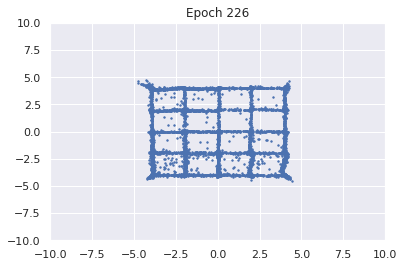

100%|██████████| 976/976 [00:07<00:00, 122.64it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.707, MI : 0.3538


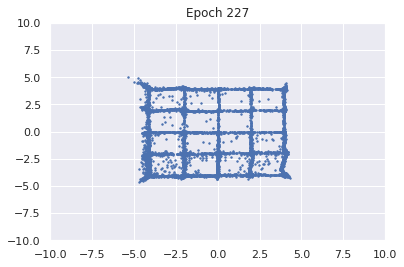

100%|██████████| 976/976 [00:07<00:00, 122.62it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7059, MI : 0.3522


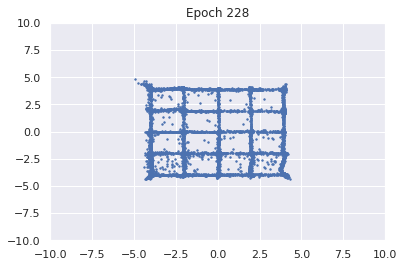

100%|██████████| 976/976 [00:07<00:00, 123.36it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7066, MI : 0.3536


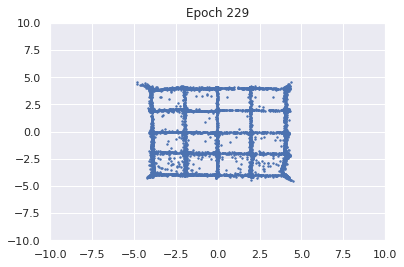

100%|██████████| 976/976 [00:07<00:00, 122.63it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7077, MI : 0.3529


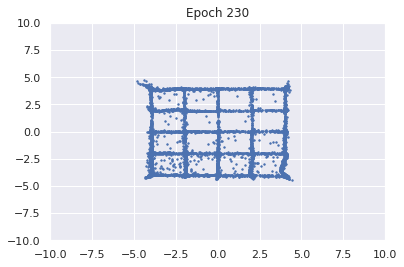

100%|██████████| 976/976 [00:07<00:00, 122.63it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7084, MI : 0.3523


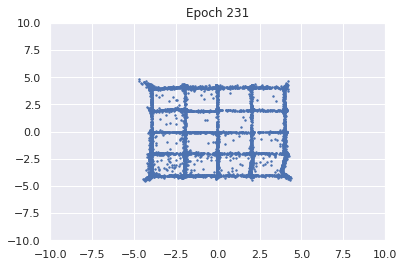

100%|██████████| 976/976 [00:07<00:00, 124.22it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7085, MI : 0.349


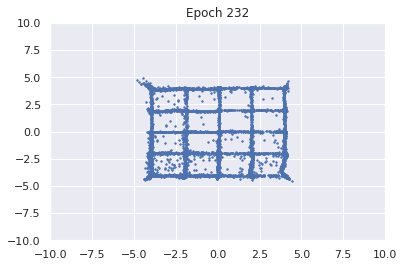

100%|██████████| 976/976 [00:07<00:00, 122.79it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7067, MI : 0.3492


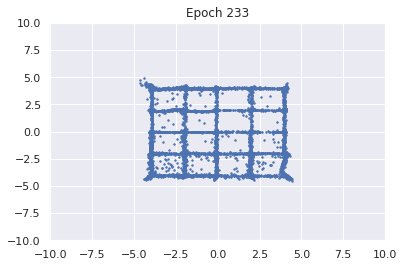

100%|██████████| 976/976 [00:07<00:00, 125.47it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.7091, MI : 0.3477


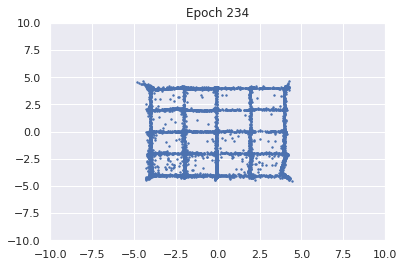

100%|██████████| 976/976 [00:07<00:00, 124.30it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7072, MI : 0.3477


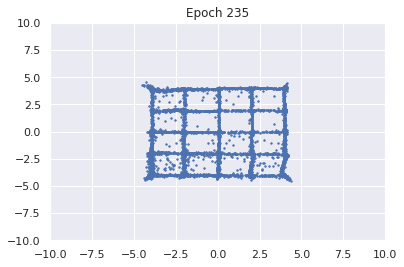

100%|██████████| 976/976 [00:07<00:00, 122.60it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.705, MI : 0.3452


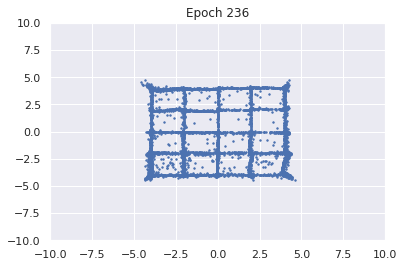

100%|██████████| 976/976 [00:07<00:00, 124.18it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7062, MI : 0.3455


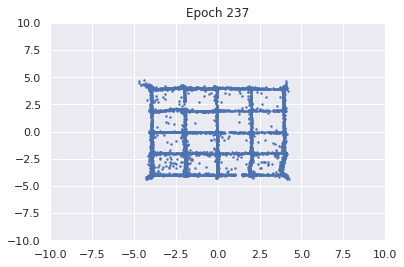

100%|██████████| 976/976 [00:07<00:00, 124.16it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.706, MI : 0.3455


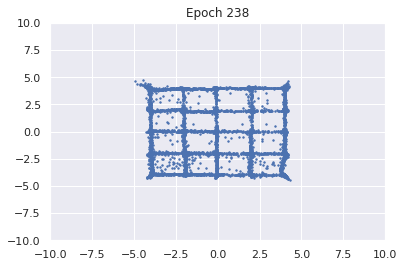

100%|██████████| 976/976 [00:08<00:00, 121.75it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7062, MI : 0.3472


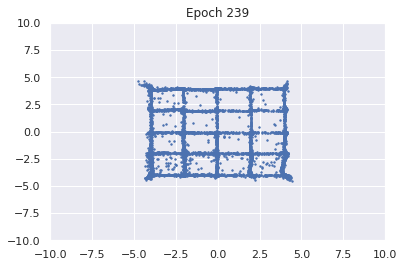

100%|██████████| 976/976 [00:07<00:00, 123.29it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.7054, MI : 0.347


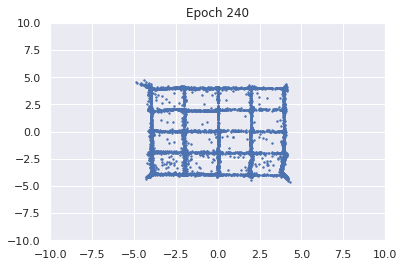

100%|██████████| 976/976 [00:07<00:00, 122.13it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.707, MI : 0.3515


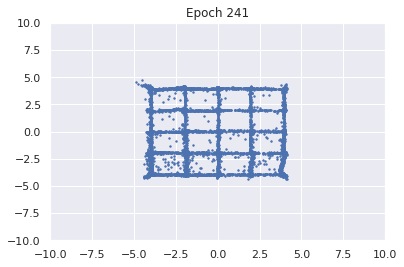

100%|██████████| 976/976 [00:07<00:00, 124.64it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7052, MI : 0.3485


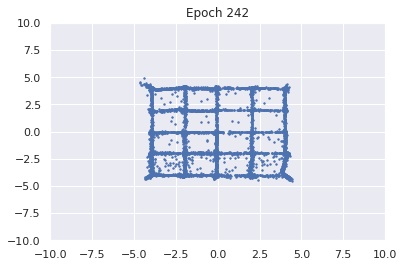

100%|██████████| 976/976 [00:07<00:00, 123.23it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7042, MI : 0.3501


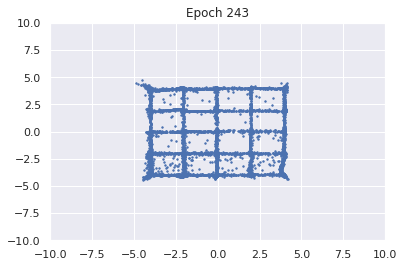

100%|██████████| 976/976 [00:07<00:00, 123.45it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7029, MI : 0.3515


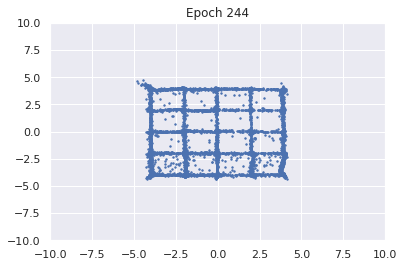

100%|██████████| 976/976 [00:08<00:00, 121.88it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7045, MI : 0.3535


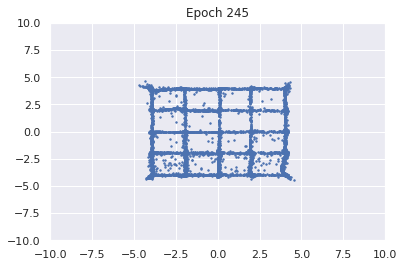

100%|██████████| 976/976 [00:07<00:00, 124.17it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7022, MI : 0.3452


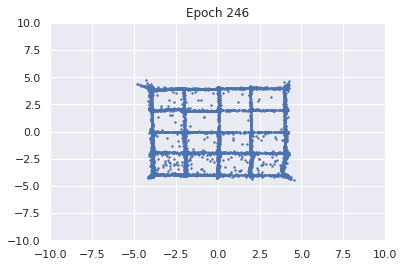

100%|██████████| 976/976 [00:07<00:00, 123.78it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.704, MI : 0.353


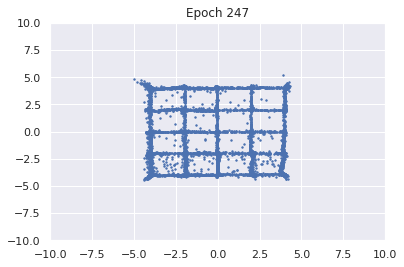

100%|██████████| 976/976 [00:07<00:00, 123.38it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7045, MI : 0.3473


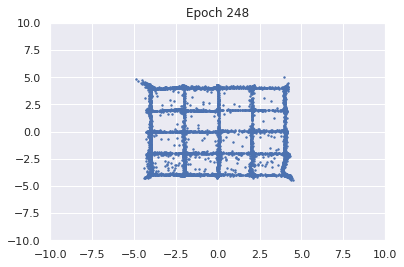

100%|██████████| 976/976 [00:07<00:00, 114.66it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7028, MI : 0.3478


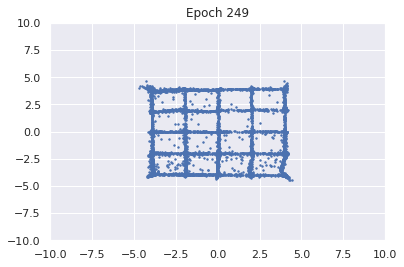

100%|██████████| 976/976 [00:07<00:00, 126.29it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.704, MI : 0.3486


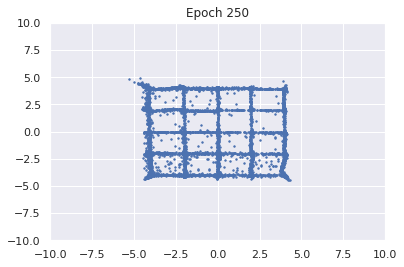

100%|██████████| 976/976 [00:07<00:00, 125.96it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7034, MI : 0.3536


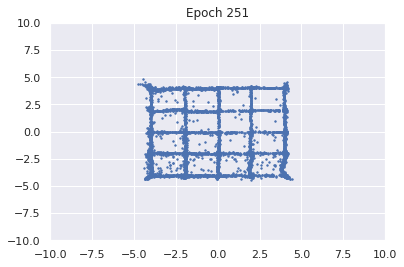

100%|██████████| 976/976 [00:07<00:00, 124.94it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.705, MI : 0.3551


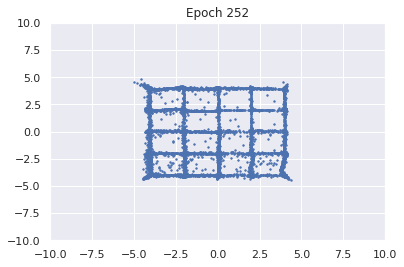

100%|██████████| 976/976 [00:08<00:00, 121.75it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7054, MI : 0.3519


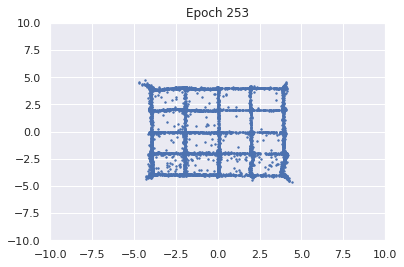

100%|██████████| 976/976 [00:07<00:00, 122.97it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7047, MI : 0.3504


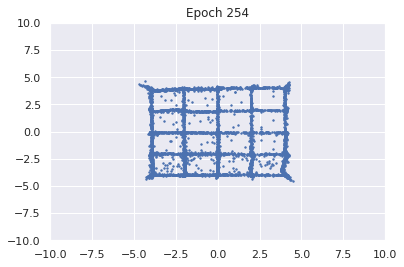

100%|██████████| 976/976 [00:07<00:00, 123.29it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7026, MI : 0.3495


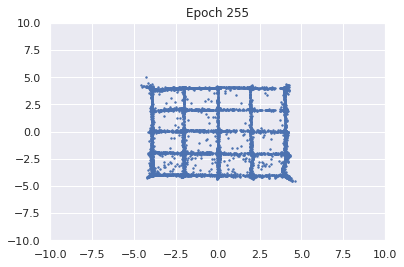

100%|██████████| 976/976 [00:07<00:00, 124.62it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7032, MI : 0.3496


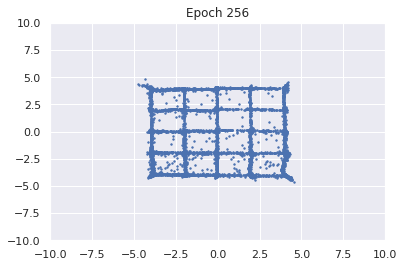

100%|██████████| 976/976 [00:07<00:00, 123.66it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7017, MI : 0.3531


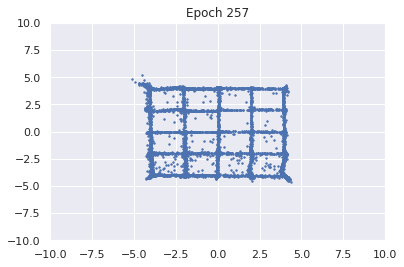

100%|██████████| 976/976 [00:07<00:00, 124.12it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7015, MI : 0.3557


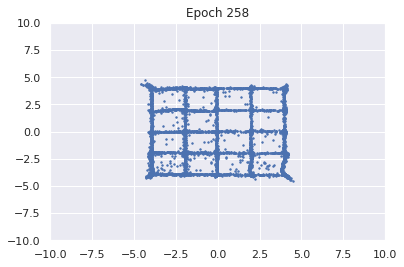

100%|██████████| 976/976 [00:07<00:00, 123.31it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7017, MI : 0.3547


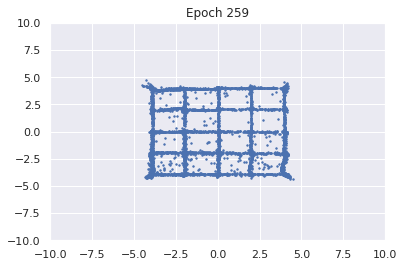

100%|██████████| 976/976 [00:07<00:00, 122.89it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7, MI : 0.3511


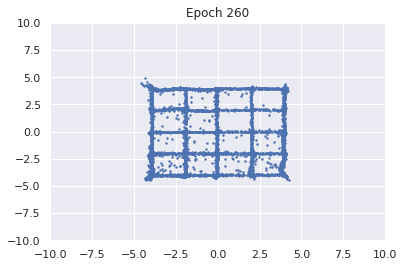

100%|██████████| 976/976 [00:07<00:00, 123.60it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7012, MI : 0.3528


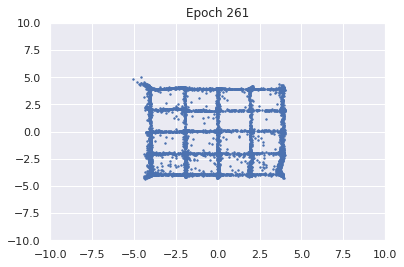

100%|██████████| 976/976 [00:07<00:00, 124.58it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6998, MI : 0.3504


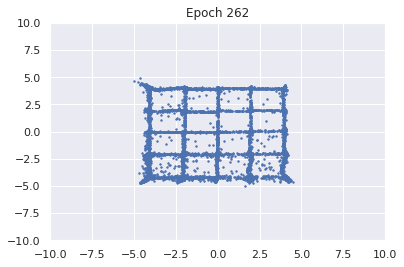

100%|██████████| 976/976 [00:07<00:00, 122.51it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6985, MI : 0.352


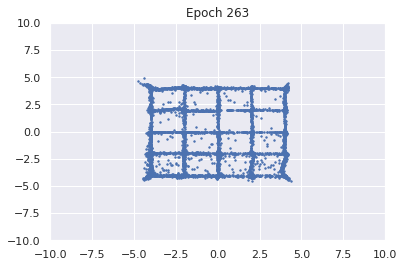

100%|██████████| 976/976 [00:08<00:00, 121.91it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.6991, MI : 0.3536


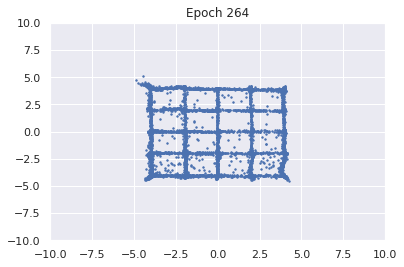

100%|██████████| 976/976 [00:07<00:00, 123.76it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.7, MI : 0.3545


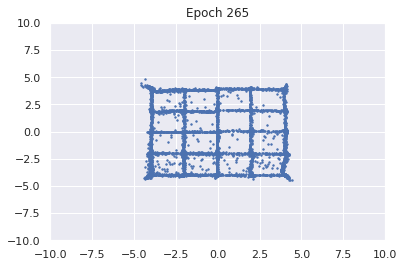

100%|██████████| 976/976 [00:07<00:00, 123.40it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.699, MI : 0.3515


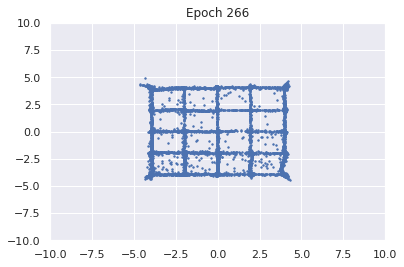

100%|██████████| 976/976 [00:07<00:00, 123.29it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.6999, MI : 0.3579


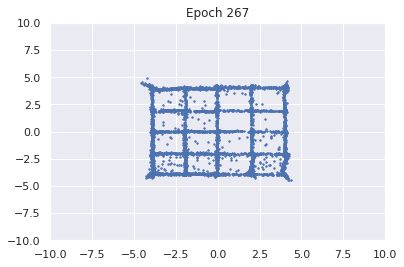

100%|██████████| 976/976 [00:07<00:00, 122.90it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6996, MI : 0.352


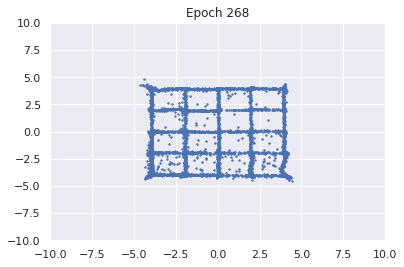

100%|██████████| 976/976 [00:07<00:00, 123.64it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6995, MI : 0.3536


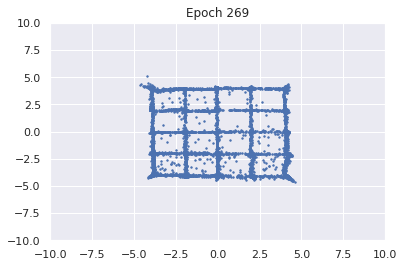

100%|██████████| 976/976 [00:07<00:00, 123.03it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.7003, MI : 0.3549


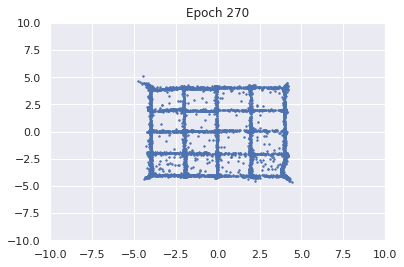

100%|██████████| 976/976 [00:07<00:00, 123.09it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6987, MI : 0.3552


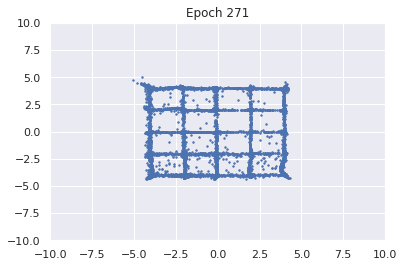

100%|██████████| 976/976 [00:07<00:00, 123.53it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6978, MI : 0.3574


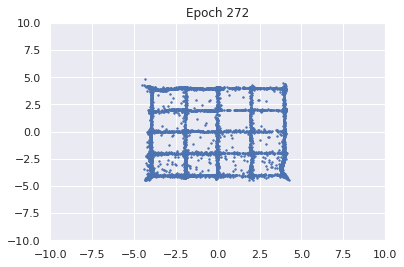

100%|██████████| 976/976 [00:07<00:00, 124.72it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6996, MI : 0.3567


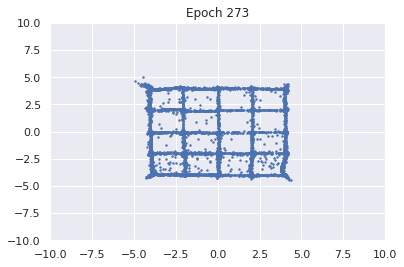

100%|██████████| 976/976 [00:07<00:00, 123.60it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6991, MI : 0.3528


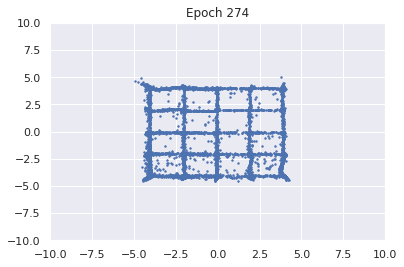

100%|██████████| 976/976 [00:07<00:00, 123.20it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6991, MI : 0.3559


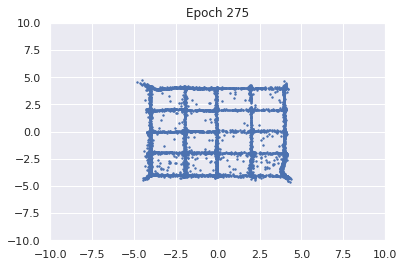

100%|██████████| 976/976 [00:07<00:00, 123.71it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6991, MI : 0.3544


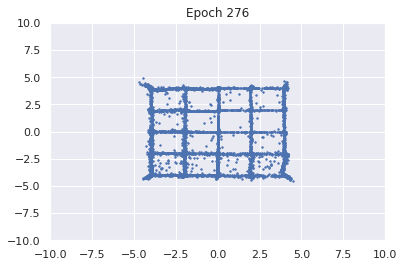

100%|██████████| 976/976 [00:07<00:00, 122.55it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6974, MI : 0.3486


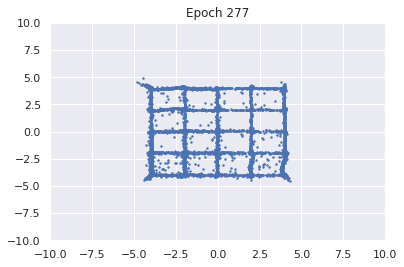

100%|██████████| 976/976 [00:07<00:00, 123.21it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.7, MI : 0.3501


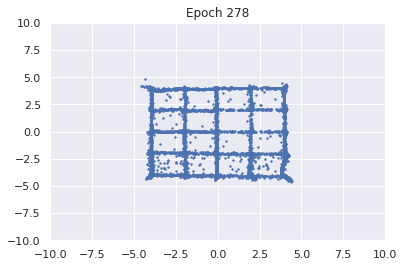

100%|██████████| 976/976 [00:07<00:00, 126.64it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6999, MI : 0.352


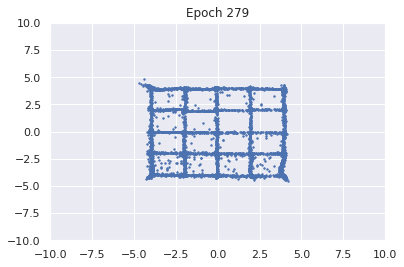

100%|██████████| 976/976 [00:07<00:00, 125.87it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6985, MI : 0.349


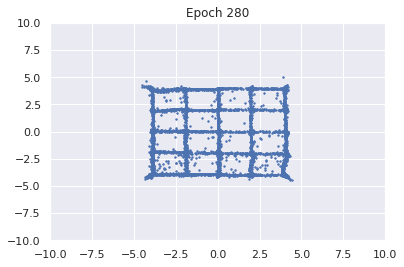

100%|██████████| 976/976 [00:07<00:00, 124.15it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6992, MI : 0.3497


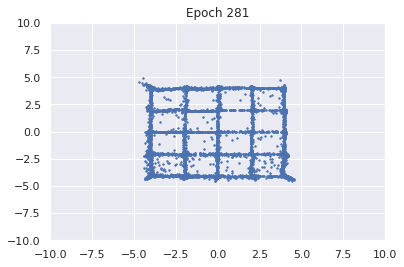

100%|██████████| 976/976 [00:07<00:00, 122.86it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6964, MI : 0.3521


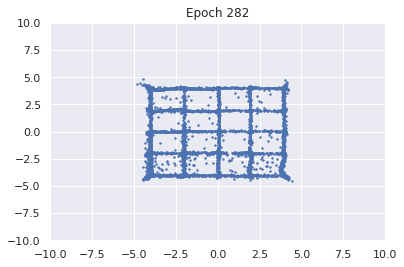

100%|██████████| 976/976 [00:07<00:00, 123.00it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6994, MI : 0.3529


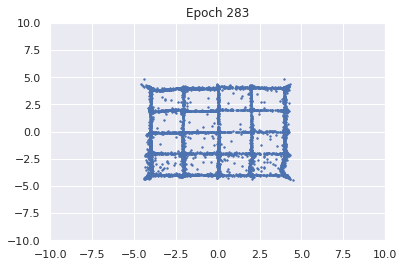

100%|██████████| 976/976 [00:07<00:00, 123.02it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6984, MI : 0.3545


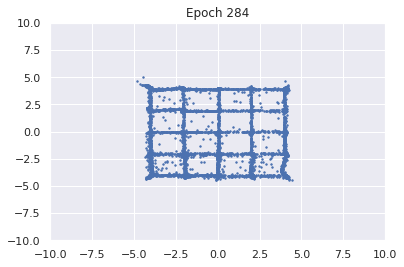

100%|██████████| 976/976 [00:07<00:00, 122.43it/s]


D loss : 1.3844, GP_loss : 0.0 G_loss : -0.6987, MI : 0.3546


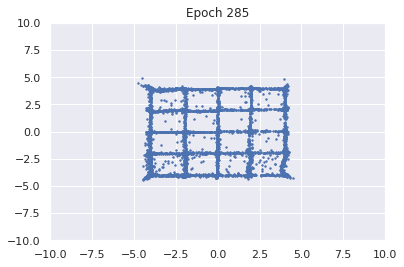

100%|██████████| 976/976 [00:07<00:00, 123.55it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6994, MI : 0.3554


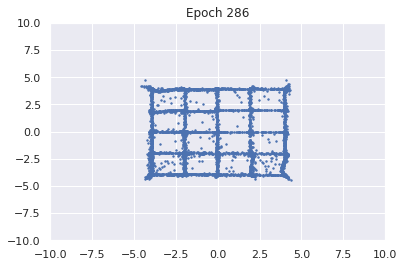

100%|██████████| 976/976 [00:07<00:00, 124.84it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6978, MI : 0.3552


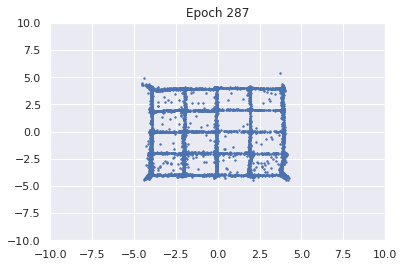

100%|██████████| 976/976 [00:07<00:00, 124.44it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6974, MI : 0.3538


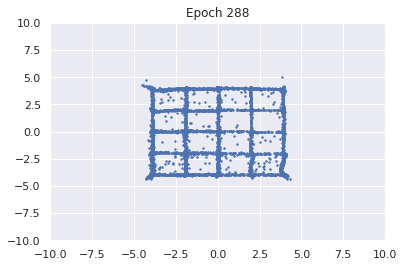

100%|██████████| 976/976 [00:07<00:00, 123.68it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6991, MI : 0.3536


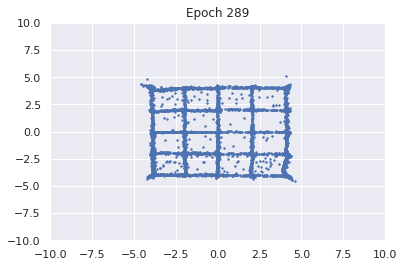

100%|██████████| 976/976 [00:07<00:00, 123.96it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6974, MI : 0.3531


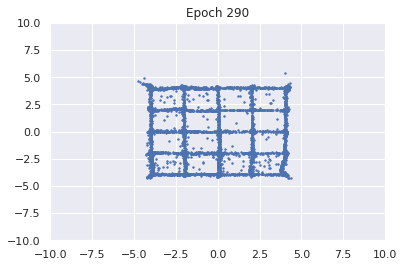

100%|██████████| 976/976 [00:07<00:00, 122.69it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6977, MI : 0.3576


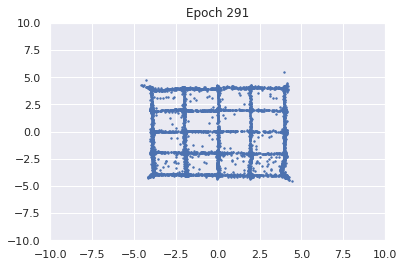

100%|██████████| 976/976 [00:07<00:00, 123.09it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6971, MI : 0.3585


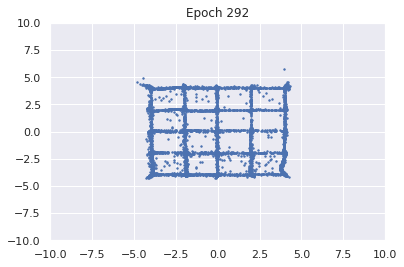

100%|██████████| 976/976 [00:07<00:00, 122.86it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6978, MI : 0.3556


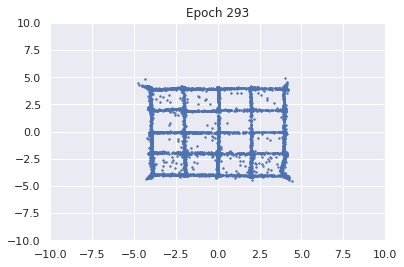

100%|██████████| 976/976 [00:07<00:00, 123.87it/s]


D loss : 1.3846, GP_loss : 0.0 G_loss : -0.6966, MI : 0.3547


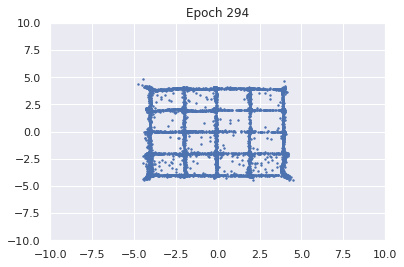

100%|██████████| 976/976 [00:08<00:00, 122.00it/s]


D loss : 1.3843, GP_loss : 0.0 G_loss : -0.6988, MI : 0.3622


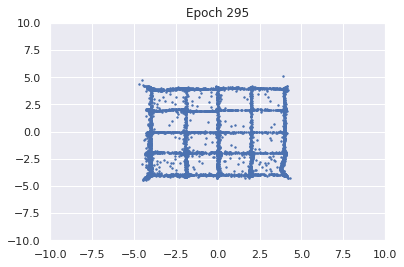

100%|██████████| 976/976 [00:08<00:00, 121.73it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6955, MI : 0.3572


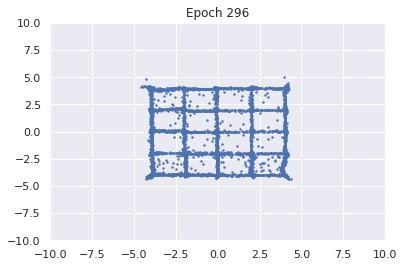

100%|██████████| 976/976 [00:08<00:00, 121.88it/s]


D loss : 1.3847, GP_loss : 0.0 G_loss : -0.6951, MI : 0.3597


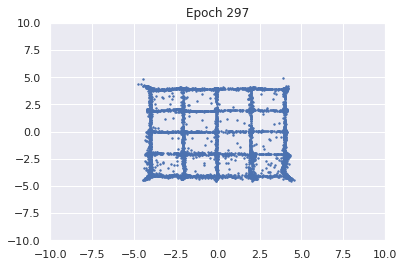

100%|██████████| 976/976 [00:07<00:00, 123.28it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6973, MI : 0.3587


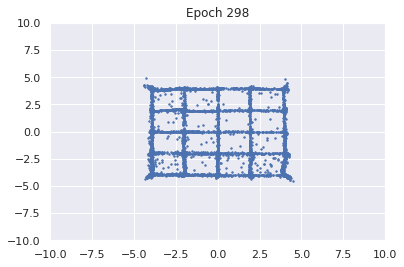

100%|██████████| 976/976 [00:07<00:00, 122.94it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6984, MI : 0.3646


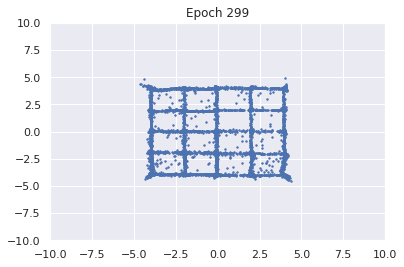

100%|██████████| 976/976 [00:07<00:00, 123.46it/s]


D loss : 1.3845, GP_loss : 0.0 G_loss : -0.6972, MI : 0.3631


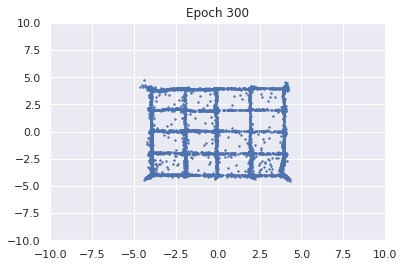

In [14]:
# MI augemented GAN
G = Generator()
G_ma = Generator()
D = Discriminator()
M = Mine()

if USE_GPU:
    G, G_ma, D, M = G.cuda(), G_ma.cuda(), D.cuda(), M.cuda()

G_ma.load_state_dict(G.state_dict())

G_opt = torch.optim.Adam(G.parameters(), lr=2e-4)
D_opt = torch.optim.Adam(D.parameters(), lr=2e-4)
M_opt = torch.optim.Adam(M.parameters(), lr=2e-4)

train(is_zero_gp=True, is_mi_obj=False)